
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_382598/989867417.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


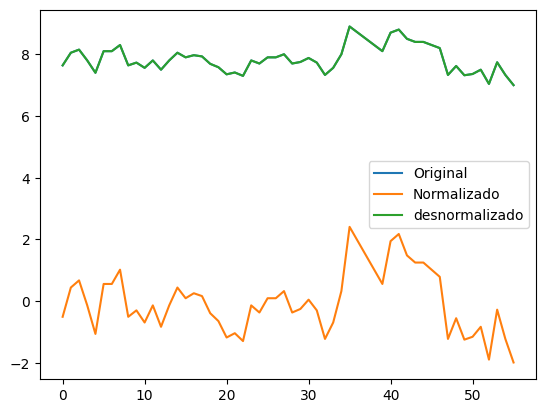

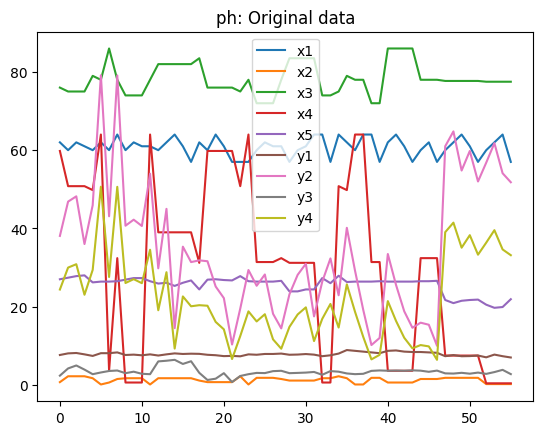

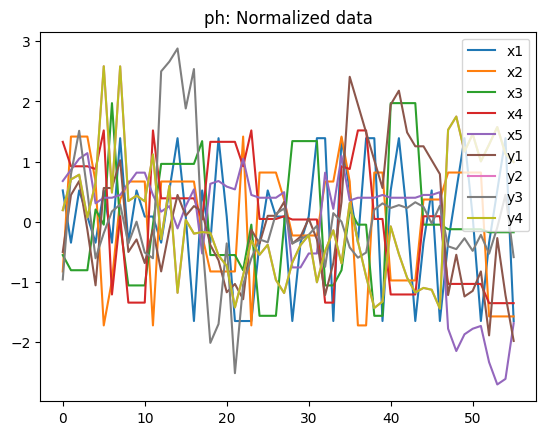

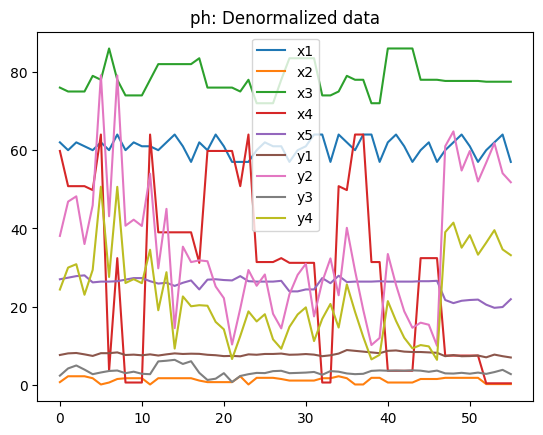

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y1"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y1")
test_out_scaler()
show_norm(label="ph")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 02:04:38.301006: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 02:04:38.331315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 02:04:38.331350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 02:04:38.332427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 02:04:38.337875: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 02:04:38.338408: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.6018364890005614
Stopped at epoch:  8
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.20315562799987674
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.19833635699978913
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.19730382700072369
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.20782152300125745
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.19856057399920246
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 7 +++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_9,0.800169,0.347413,0.079222,0.309131,0.037384,0.136368,0.091111,0.115071
model_3_3_8,0.803989,0.378892,0.095669,0.334638,0.036669,0.129790,0.089484,0.110822
model_3_3_7,0.807747,0.412808,0.115058,0.362585,0.035966,0.122703,0.087565,0.106167
model_3_3_0,0.809776,0.678127,0.405511,0.620011,0.035587,0.067260,0.058825,0.063291
model_3_3_6,0.811319,0.449087,0.138178,0.393145,0.035298,0.115122,0.085277,0.101077
model_3_3_5,0.814531,0.487487,0.166065,0.426446,0.034697,0.107098,0.082518,0.095531
model_3_3_1,0.815984,0.644929,0.345862,0.581285,0.034425,0.074198,0.064727,0.069741
model_3_3_4,0.817119,0.527470,0.199970,0.462482,0.034213,0.098742,0.079163,0.089529
model_3_3_2,0.818599,0.607806,0.290113,0.541042,0.033936,0.081955,0.070243,0.076444
model_3_3_3,0.818683,0.568071,0.241133,0.500957,0.033920,0.090258,0.075090,0.083120


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.1830645199988794
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.23549738800102205
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.18192526500024542
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.2696112850007921
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.1775295340012235
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.238055252999402
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.26886640100

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_11,0.803776,0.654644,-2.598099,0.125462,0.036709,0.070230,0.162359,0.113585
model_3_4_0,0.807816,0.843813,-0.263763,0.663917,0.035953,0.031761,0.057025,0.043650
model_3_4_10,0.808469,0.660754,-2.411586,0.161020,0.035831,0.068988,0.153943,0.108966
model_3_4_9,0.813031,0.667729,-2.214118,0.199088,0.034978,0.067569,0.145032,0.104022
model_3_4_1,0.815207,0.793747,-0.460803,0.590201,0.034571,0.041943,0.065916,0.053225
model_3_4_8,0.817293,0.675696,-2.006743,0.239595,0.034180,0.065949,0.135675,0.098761
model_3_4_2,0.820947,0.760739,-0.669362,0.528743,0.033497,0.048655,0.075327,0.061207
model_3_4_7,0.821037,0.684799,-1.790936,0.282424,0.033480,0.064098,0.125937,0.093198
model_3_4_6,0.823993,0.695213,-1.568619,0.327404,0.032927,0.061980,0.115905,0.087357
model_3_4_3,0.824650,0.738326,-0.888641,0.474314,0.032804,0.053213,0.085222,0.068276


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.1896952710012556
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.2898516009990999
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.2658880520011735
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.26717698900029063
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.1868732450002426
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.2563750389999768
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.21980753600

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.806281,0.717662,0.929337,0.852757,0.036240,0.047513,0.017405,0.033344
model_3_5_6,0.814106,0.663959,0.474964,0.599064,0.034777,0.056550,0.129322,0.090796
model_3_5_5,0.829679,0.687841,0.587624,0.666123,0.031863,0.052531,0.101573,0.075610
model_3_5_1,0.833888,0.732633,0.918079,0.852885,0.031076,0.044994,0.020178,0.033316
model_3_5_4,0.841675,0.709245,0.694662,0.729330,0.029619,0.048929,0.075208,0.061296
model_3_5_2,0.846639,0.734708,0.868168,0.828155,0.028690,0.044644,0.032472,0.038916
model_3_5_3,0.848176,0.725859,0.790616,0.784979,0.028403,0.046134,0.051574,0.048694


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.2701578090000112
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.2297886180003843
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.25776025999948615
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.2383765670001594
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.18598985700009507
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.22542752200024552
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.217160193

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_3,0.801570,0.186030,0.578280,0.450011,0.037122,0.102325,0.102151,0.102243
model_3_7_0,0.807848,0.313192,0.688368,0.563038,0.035947,0.086339,0.075485,0.081231
model_3_7_2,0.810395,0.229636,0.640571,0.503817,0.035471,0.096843,0.087063,0.092241
model_3_7_1,0.813722,0.272507,0.682881,0.545108,0.034848,0.091454,0.076814,0.084565


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.2859853039990412
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.23983705300088332
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.1762626920008188
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.32098358099938196
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.14941133400134277
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.22666866799954732
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.38040187

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.801417,0.744265,0.899529,0.825906,0.037150,0.052805,0.019847,0.037295
model_3_8_5,0.803210,0.563700,0.525018,0.571256,0.036815,0.090089,0.093826,0.091848
model_3_8_4,0.810091,0.597217,0.605753,0.623393,0.035528,0.083168,0.077878,0.080679
model_3_8_1,0.811937,0.708559,0.835316,0.779822,0.035182,0.060178,0.032531,0.047168
model_3_8_3,0.814518,0.632822,0.685488,0.676161,0.034700,0.075816,0.062127,0.069374
model_3_8_2,0.815584,0.670300,0.762763,0.728816,0.034500,0.068078,0.046863,0.058094


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.1788079510006355
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.19609943500108784
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.25001581799915584
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.27798566700039373
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.23607556100068905
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.40468171799875563
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.1678726

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_10,0.800466,0.335698,-0.465465,-0.085727,0.037328,0.060953,0.168526,0.111576
model_4_9_9,0.814835,0.417597,-0.325662,0.026608,0.034640,0.053439,0.152449,0.100032
model_4_9_0,0.816628,0.928287,0.726842,0.822256,0.034305,0.006580,0.031413,0.018266
model_4_9_8,0.829430,0.502168,-0.173945,0.146477,0.031910,0.045679,0.135002,0.087713
model_4_9_1,0.838825,0.904483,0.665781,0.778850,0.030152,0.008764,0.038435,0.022727
model_4_9_7,0.843460,0.587325,-0.014652,0.270614,0.029285,0.037865,0.116683,0.074956
model_4_9_2,0.854230,0.879540,0.594357,0.729447,0.027270,0.011053,0.046648,0.027804
model_4_9_6,0.855703,0.670104,0.144408,0.393505,0.026995,0.030270,0.098392,0.062327
model_4_9_3,0.863907,0.851081,0.512772,0.673032,0.025460,0.013664,0.056030,0.033601
model_4_9_5,0.864407,0.746462,0.291157,0.506876,0.025366,0.023264,0.081516,0.050676


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.3459485009989294
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.2977013390009233
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.1403589910005394
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.16690550000021176
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.14077857899974333
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.13676883100015402
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.806281,0.849074,0.822285,0.837866,0.036240,0.035317,0.056925,0.045485
model_5_3_1,0.827381,0.848460,0.817512,0.835029,0.032293,0.035460,0.058454,0.046281
model_5_3_2,0.844177,0.847745,0.812372,0.831952,0.029151,0.035628,0.060101,0.047144
model_5_3_3,0.857458,0.846799,0.806851,0.828568,0.026666,0.035849,0.061869,0.048094
model_5_3_4,0.867873,0.845592,0.801005,0.824894,0.024718,0.036132,0.063742,0.049125
model_5_3_5,0.875960,0.844140,0.794937,0.820993,0.023205,0.036471,0.065685,0.050219
model_5_3_6,0.882162,0.842474,0.788766,0.816941,0.022045,0.036861,0.067662,0.051356
model_5_3_7,0.886844,0.840631,0.782621,0.812825,0.021169,0.037292,0.069631,0.052510
model_5_3_8,0.890316,0.838668,0.776623,0.808735,0.020520,0.037752,0.071552,0.053658
model_5_3_9,0.892833,0.836649,0.770875,0.804756,0.020048,0.038224,0.073393,0.054774


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.2625954469986027
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.14006111699927715
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.14402726200023608
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.14100908699947468
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.1477999329999875
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.16921463300059258
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.1598151

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.882054,-0.059268,0.341977,0.326123,0.022065,0.107554,0.033358,0.072638
model_5_4_23,0.882759,-0.051360,0.342814,0.330252,0.021933,0.106751,0.033315,0.072193
model_5_4_22,0.883535,-0.042619,0.343733,0.334814,0.021788,0.105863,0.033269,0.071701
model_5_4_21,0.884388,-0.032967,0.344734,0.339849,0.021628,0.104883,0.033218,0.071158
model_5_4_20,0.885327,-0.022312,0.345827,0.345405,0.021453,0.103801,0.033162,0.070559
model_5_4_19,0.886356,-0.010557,0.347015,0.351530,0.021260,0.102608,0.033102,0.069899
model_5_4_18,0.887485,0.002395,0.348303,0.358274,0.021049,0.101293,0.033037,0.069172
model_5_4_17,0.888720,0.016652,0.349695,0.365691,0.020818,0.099845,0.032966,0.068373
model_5_4_16,0.890067,0.032328,0.351191,0.373840,0.020566,0.098253,0.032891,0.067494
model_5_4_15,0.891534,0.049540,0.352789,0.382777,0.020292,0.096506,0.032810,0.066531


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.14443816800121567
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.14075913700071396
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.14152276999993774
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.13956586999847787
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.14021756799957075
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.13932796100016276
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.139040

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.900461,0.669228,0.922232,0.774750,0.018621,0.056926,0.008823,0.034289
model_5_5_1,0.914394,0.711903,0.914550,0.797599,0.016015,0.049581,0.009694,0.030811
model_5_5_2,0.924771,0.744340,0.901390,0.812397,0.014074,0.043999,0.011187,0.028558
model_5_5_3,0.932360,0.768577,0.884701,0.821051,0.012654,0.039828,0.013081,0.027241
model_5_5_24,0.934946,0.786395,0.616912,0.737797,0.012170,0.036761,0.043461,0.039914
model_5_5_23,0.935619,0.788370,0.622087,0.740795,0.012044,0.036421,0.042874,0.039458
model_5_5_22,0.936343,0.790489,0.627780,0.744059,0.011909,0.036057,0.042228,0.038961
model_5_5_21,0.937117,0.792750,0.634033,0.747605,0.011764,0.035667,0.041519,0.038421
model_5_5_4,0.937785,0.786319,0.865997,0.825110,0.011639,0.036774,0.015203,0.026623
model_5_5_20,0.937940,0.795145,0.640894,0.751445,0.011610,0.035255,0.040741,0.037837


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.8560901840010047
Stopped at epoch:  29
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.1389224499998818
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.14155000600112544
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.13864820999879157
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.14122910399964894
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.1507281080012035
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.14895632

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.984092,0.966968,0.919232,0.950400,0.002976,0.006794,0.012837,0.009638
model_5_6_1,0.984144,0.966906,0.919329,0.950403,0.002966,0.006807,0.012821,0.009637
model_5_6_2,0.984185,0.966846,0.919414,0.950402,0.002959,0.006819,0.012808,0.009637
model_5_6_3,0.984217,0.966790,0.919488,0.950399,0.002953,0.006831,0.012796,0.009638
model_5_6_4,0.984243,0.966737,0.919552,0.950394,0.002948,0.006842,0.012786,0.009639
model_5_6_5,0.984263,0.966687,0.919609,0.950387,0.002944,0.006852,0.012777,0.009640
model_5_6_6,0.984278,0.966640,0.919658,0.950380,0.002941,0.006862,0.012769,0.009642
model_5_6_7,0.984291,0.966597,0.919702,0.950373,0.002939,0.006871,0.012762,0.009643
model_5_6_8,0.984300,0.966557,0.919740,0.950365,0.002937,0.006879,0.012756,0.009645
model_5_6_9,0.984307,0.966520,0.919774,0.950358,0.002936,0.006886,0.012751,0.009646


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.14520590400024957
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.1412477329995454
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.14020981500107155
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.14145940800153767
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.21439250499861373
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.2725822259999404
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.14363447

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.986203,0.858211,0.987816,0.946907,0.002581,0.008895,0.001233,0.005289
model_5_7_1,0.987681,0.869099,0.986519,0.949917,0.002305,0.008212,0.001364,0.004990
model_5_7_2,0.988836,0.878092,0.984808,0.952096,0.002089,0.007648,0.001538,0.004772
model_5_7_3,0.989733,0.885533,0.982824,0.953629,0.001921,0.007181,0.001738,0.004620
model_5_7_4,0.990426,0.891697,0.980679,0.954658,0.001791,0.006794,0.001955,0.004517
model_5_7_5,0.990956,0.896813,0.978455,0.955301,0.001692,0.006473,0.002181,0.004453
model_5_7_6,0.991358,0.901066,0.976217,0.955648,0.001617,0.006206,0.002407,0.004419
model_5_7_7,0.991658,0.904611,0.974009,0.955774,0.001561,0.005984,0.002631,0.004406
model_5_7_8,0.991878,0.907569,0.971865,0.955735,0.001519,0.005798,0.002848,0.004410
model_5_7_9,0.992036,0.910045,0.969807,0.955577,0.001490,0.005643,0.003056,0.004426


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.2436971250008355
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.1450758049995784
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.14353530399966985
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.14433508399997663
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.13987719399847265
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.14356735000001208
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.15809703

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.983576,0.711055,0.935919,0.903741,0.003072,0.008378,0.012033,0.010098
model_5_8_23,0.983834,0.715116,0.937071,0.905306,0.003024,0.008260,0.011817,0.009934
model_5_8_22,0.984117,0.719595,0.938338,0.907029,0.002971,0.008130,0.011579,0.009753
model_5_8_21,0.984426,0.724528,0.939729,0.908922,0.002914,0.007987,0.011318,0.009555
model_5_8_20,0.984763,0.729956,0.941253,0.911000,0.002851,0.007830,0.011032,0.009337
model_5_8_19,0.985131,0.735920,0.942922,0.913279,0.002782,0.007657,0.010718,0.009098
model_5_8_18,0.985530,0.742467,0.944745,0.915772,0.002707,0.007467,0.010376,0.008836
model_5_8_17,0.985963,0.749639,0.946732,0.918496,0.002626,0.007259,0.010003,0.008550
model_5_8_16,0.986430,0.757482,0.948893,0.921464,0.002539,0.007032,0.009597,0.008239
model_5_8_15,0.986932,0.766042,0.951236,0.924690,0.002445,0.006784,0.009157,0.007901


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.20427753100011614
Stopped at epoch:  9
1/1 [==============================] - 0s 13ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.1463708499995846
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.1379054589997395
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.14198551300069084
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.2329746060004254
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.1439119370006665
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.1429770959

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.990371,0.930070,0.977872,0.946048,0.001801,0.009654,0.001724,0.005922
model_5_9_23,0.990437,0.930546,0.978119,0.946448,0.001789,0.009588,0.001704,0.005878
model_5_9_0,0.990506,0.949712,0.992710,0.964082,0.001776,0.006942,0.000568,0.003942
model_5_9_22,0.990510,0.931070,0.978391,0.946888,0.001775,0.009516,0.001683,0.005830
model_5_9_21,0.990589,0.931645,0.978690,0.947370,0.001761,0.009436,0.001660,0.005777
model_5_9_20,0.990675,0.932275,0.979019,0.947900,0.001745,0.009349,0.001634,0.005719
model_5_9_19,0.990767,0.932964,0.979381,0.948480,0.001727,0.009254,0.001606,0.005655
model_5_9_18,0.990867,0.933717,0.979778,0.949113,0.001709,0.009150,0.001575,0.005586
model_5_9_17,0.990974,0.934536,0.980212,0.949803,0.001689,0.009037,0.001541,0.005510
model_5_9_16,0.991087,0.935425,0.980686,0.950554,0.001667,0.008914,0.001505,0.005427


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.371960978000061
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.17339797699969495
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.18722315200102457
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.13938655399942945
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.1446597930007556
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.13912232399889035
Stopped at epoch:  6
1/1 [==============================] - 0s 1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_8,0.807594,0.554895,0.300183,0.468301,0.035995,0.058111,0.155778,0.104072
model_6_3_0,0.812337,0.744486,0.800466,0.802988,0.035107,0.033359,0.044416,0.038562
model_6_3_7,0.815659,0.590717,0.355708,0.510666,0.034486,0.053434,0.143418,0.095780
model_6_3_6,0.822950,0.625532,0.414648,0.554503,0.033122,0.048889,0.130299,0.087199
model_6_3_1,0.824735,0.736942,0.737146,0.766436,0.032788,0.034344,0.058511,0.045717
model_6_3_5,0.828898,0.657934,0.476319,0.598950,0.032009,0.044659,0.116571,0.078500
model_6_3_2,0.831600,0.725920,0.671253,0.727280,0.031504,0.035783,0.073179,0.053381
model_6_3_4,0.832830,0.686320,0.540041,0.643076,0.031274,0.040953,0.102386,0.069863
model_6_3_3,0.833998,0.709232,0.605213,0.686045,0.031055,0.037961,0.087879,0.061452


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.15055256899904634
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.18290593000165245
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.14268164500026614
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.1394649030007713
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.1391138669987413
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.14024522500039893
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.14494755

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.818095,0.851892,0.730411,0.810822,0.034030,0.037629,0.046702,0.041899
model_6_4_1,0.832976,0.849466,0.682830,0.791835,0.031246,0.038246,0.054945,0.046104
model_6_4_2,0.844122,0.845960,0.640469,0.774114,0.029161,0.039136,0.062284,0.050029
model_6_4_3,0.852635,0.841845,0.604508,0.758378,0.027569,0.040182,0.068513,0.053514
model_6_4_4,0.859094,0.837293,0.574088,0.744416,0.026360,0.041338,0.073783,0.056607
model_6_4_5,0.863918,0.832482,0.548188,0.731961,0.025458,0.042561,0.078270,0.059365
model_6_4_6,0.867446,0.827586,0.525954,0.720804,0.024798,0.043805,0.082122,0.061836
model_6_4_22,0.868536,0.777843,0.381156,0.637297,0.024594,0.056443,0.107206,0.080331
model_6_4_21,0.869076,0.779379,0.384675,0.639525,0.024493,0.056053,0.106596,0.079838
model_6_4_20,0.869640,0.781067,0.388579,0.641988,0.024387,0.055623,0.105920,0.079292


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.16396530600104597
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.13903238600141776
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.1416780950003158
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.23347499100054847
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.13827913900058775
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.14000010999916412
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.1377725

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_24,0.878731,0.694281,0.562282,0.678602,0.022687,0.058230,0.093020,0.074602
model_6_5_23,0.879260,0.696165,0.563947,0.680138,0.022588,0.057871,0.092666,0.074245
model_6_5_22,0.879833,0.698238,0.565769,0.681824,0.022480,0.057476,0.092279,0.073854
model_6_5_21,0.880454,0.700517,0.567764,0.683673,0.022364,0.057042,0.091855,0.073425
model_6_5_20,0.881123,0.703020,0.569940,0.685698,0.022239,0.056566,0.091392,0.072955
model_6_5_19,0.881841,0.705764,0.572312,0.687912,0.022105,0.056043,0.090888,0.072441
model_6_5_0,0.881981,0.828125,0.651328,0.775111,0.022079,0.032737,0.074097,0.052200
model_6_5_18,0.882609,0.708771,0.574890,0.690329,0.021961,0.055470,0.090340,0.071880
model_6_5_17,0.883424,0.712061,0.577686,0.692962,0.021809,0.054844,0.089746,0.071268
model_6_5_16,0.884286,0.715656,0.580709,0.695827,0.021648,0.054159,0.089104,0.070604


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.203008836000663
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.14338455299912312
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.13858459099901665
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.13875412299967138
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.14238816899887752
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.13823179900100513
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.13772492

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.888897,0.601862,0.756362,0.683850,0.020785,0.092113,0.041771,0.068423
model_6_6_23,0.889189,0.601610,0.759105,0.684730,0.020730,0.092171,0.041301,0.068232
model_6_6_22,0.889507,0.601329,0.762126,0.685697,0.020671,0.092236,0.040783,0.068023
model_6_6_21,0.889854,0.601017,0.765451,0.686760,0.020606,0.092308,0.040213,0.067793
model_6_6_20,0.890231,0.600668,0.769106,0.687925,0.020535,0.092389,0.039586,0.067541
model_6_6_19,0.890639,0.600279,0.773120,0.689202,0.020459,0.092479,0.038898,0.067264
model_6_6_18,0.891080,0.599846,0.777520,0.690597,0.020376,0.092579,0.038144,0.066962
model_6_6_17,0.891554,0.599363,0.782337,0.692119,0.020288,0.092691,0.037318,0.066633
model_6_6_16,0.892060,0.598823,0.787601,0.693776,0.020193,0.092816,0.036415,0.066274
model_6_6_15,0.892599,0.598219,0.793342,0.695574,0.020092,0.092955,0.035431,0.065885


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.14990121700066084
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.1398878500003775
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.13901182999870798
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.2856401860008191
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.13677853099943604
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.1421850730002916
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.138758397

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.843555,0.125606,0.743049,0.424711,0.029267,0.143869,0.042502,0.096167
model_6_7_23,0.846783,0.142616,0.750305,0.436954,0.028663,0.141070,0.041302,0.094121
model_6_7_22,0.850297,0.161241,0.758179,0.450326,0.028006,0.138006,0.040000,0.091885
model_6_7_21,0.854109,0.181589,0.766697,0.464895,0.027293,0.134658,0.038591,0.089450
model_6_7_20,0.858232,0.203781,0.775879,0.480735,0.026522,0.131007,0.037072,0.086802
model_6_7_19,0.862674,0.227915,0.785731,0.497899,0.025691,0.127036,0.035442,0.083933
model_6_7_18,0.867440,0.254088,0.796252,0.516436,0.024799,0.122729,0.033702,0.080834
model_6_7_17,0.872523,0.282364,0.807423,0.536372,0.023848,0.118077,0.031854,0.077502
model_6_7_16,0.877910,0.312772,0.819209,0.557706,0.022840,0.113074,0.029905,0.073935
model_6_7_15,0.883570,0.345276,0.831548,0.580389,0.021781,0.107725,0.027864,0.070144


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  2.2478567420002946
Stopped at epoch:  108
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.14124483799969312
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.46767725000063365
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.13747512199915946
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.1581330099998013
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.1388514380014385
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.309603

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_12,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_22,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_21,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_20,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_19,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_18,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_17,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_16,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_15,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194
model_6_8_14,0.944513,0.826261,0.385017,0.787416,0.01038,0.024864,0.04469,0.034194


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.03028169500066724
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.024652693999087205
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.02385387599861133
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.023927629001263995
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.02333241300038935
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.02458027799912088
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.0238

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_22,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_21,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_20,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_19,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_18,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_17,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_16,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_15,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799
model_6_9_14,0.944513,0.796446,0.971363,0.890416,0.01038,0.030705,0.005404,0.018799


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.4414350850001938
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.14181614799963427
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.1494153389994608
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.1407257409991871
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.1951159309992363
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.18111381199923926
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_23,0.810363,-0.318428,0.880989,0.299182,0.035477,0.201221,0.020717,0.116278
model_7_5_22,0.812016,-0.305543,0.882398,0.306152,0.035168,0.199255,0.020472,0.115122
model_7_5_0,0.812803,0.552387,0.952246,0.758440,0.035020,0.068316,0.008313,0.040079
model_7_5_21,0.813813,-0.291298,0.883942,0.313852,0.034831,0.197081,0.020203,0.113844
model_7_5_20,0.815760,-0.275557,0.885629,0.322350,0.034467,0.194678,0.019909,0.112434
model_7_5_19,0.817863,-0.258175,0.887469,0.331724,0.034074,0.192025,0.019589,0.110879
model_7_5_18,0.820124,-0.238996,0.889473,0.342053,0.033651,0.189098,0.019240,0.109165
model_7_5_17,0.822544,-0.217856,0.891650,0.353423,0.033198,0.185872,0.018861,0.107279
model_7_5_16,0.825116,-0.194578,0.894009,0.365924,0.032717,0.182319,0.018450,0.105204
model_7_5_15,0.827833,-0.168976,0.896558,0.379650,0.032209,0.178412,0.018007,0.102927


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.38635666299887816
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.1466784620006365
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.16296227499879024
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.14419697999983327
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.14307463700060907
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.1452999249995628
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.14622740

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.843133,0.980417,0.947568,0.969338,0.029346,0.005371,0.008254,0.006728
model_7_6_1,0.871545,0.983082,0.939838,0.968492,0.024031,0.004640,0.009471,0.006913
model_7_6_2,0.894138,0.983178,0.929941,0.965214,0.019804,0.004614,0.011029,0.007632
model_7_6_3,0.910655,0.981167,0.916336,0.959290,0.016714,0.005165,0.013170,0.008932
model_7_6_24,0.920040,0.824358,0.686350,0.777869,0.014959,0.048173,0.049374,0.048738
model_7_6_23,0.921232,0.828057,0.690722,0.781793,0.014736,0.047159,0.048686,0.047878
model_7_6_4,0.922335,0.977178,0.899134,0.950843,0.014529,0.006259,0.015878,0.010786
model_7_6_22,0.922517,0.832134,0.695524,0.786112,0.014495,0.046041,0.047930,0.046930
model_7_6_21,0.923895,0.836618,0.700790,0.790858,0.014238,0.044811,0.047101,0.045889
model_7_6_20,0.925363,0.841543,0.706559,0.796064,0.013963,0.043460,0.046193,0.044746


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.2626259360004042
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.1440053389997047
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.14123725999888848
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.1414729959997203
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.13973298000018985
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.21242012500079
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.22756707700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.922252,0.781729,0.841017,0.820999,0.014545,0.040062,0.056665,0.047875
model_7_7_23,0.923016,0.783718,0.842723,0.822792,0.014402,0.039697,0.056057,0.047396
model_7_7_22,0.923853,0.785898,0.844602,0.824762,0.014245,0.039297,0.055387,0.046869
model_7_7_21,0.924771,0.788287,0.846670,0.826927,0.014074,0.038859,0.054650,0.046290
model_7_7_20,0.925774,0.790898,0.848943,0.829301,0.013886,0.038379,0.053840,0.045655
model_7_7_19,0.926870,0.793750,0.851437,0.831901,0.013681,0.037856,0.052951,0.044959
model_7_7_18,0.928062,0.796855,0.854171,0.834744,0.013458,0.037286,0.051976,0.044199
model_7_7_17,0.929357,0.800228,0.857159,0.837843,0.013216,0.036667,0.050911,0.043370
model_7_7_16,0.930758,0.803884,0.860418,0.841215,0.012954,0.035996,0.049749,0.042468
model_7_7_15,0.932268,0.807833,0.863965,0.844874,0.012671,0.035271,0.048485,0.041490


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.15049816200007626
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.15369362399906095
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.14282465600081196
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.14521910400071647
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.1496389519998047
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.14180189600119775
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.1429640

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.934729,0.951670,0.995865,0.976014,0.012211,0.009441,0.000721,0.005337
model_7_8_1,0.944233,0.946959,0.992648,0.972639,0.010433,0.010361,0.001282,0.006088
model_7_8_2,0.951357,0.940889,0.988539,0.968303,0.009100,0.011546,0.001998,0.007053
model_7_8_3,0.956589,0.933813,0.983856,0.963288,0.008121,0.012929,0.002814,0.008169
model_7_8_24,0.956598,0.804312,0.923384,0.880807,0.008120,0.038225,0.013357,0.026522
model_7_8_23,0.957117,0.807157,0.924335,0.882479,0.008023,0.037669,0.013191,0.026150
model_7_8_22,0.957675,0.810278,0.925390,0.884319,0.007918,0.037060,0.013007,0.025741
model_7_8_21,0.958275,0.813695,0.926562,0.886339,0.007806,0.036392,0.012803,0.025291
model_7_8_20,0.958914,0.817432,0.927862,0.888555,0.007686,0.035662,0.012576,0.024798
model_7_8_19,0.959592,0.821508,0.929305,0.890981,0.007559,0.034866,0.012325,0.024258


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.15067475300020305
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.14346337099959783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.14665631400021084
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.1569908960009343
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.1481915599997592
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.1393590600000607
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.141010504

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.950991,0.858352,0.869924,0.878352,0.009169,0.025383,0.035358,0.030077
model_7_9_23,0.951745,0.860713,0.872033,0.880349,0.009028,0.024960,0.034785,0.029584
model_7_9_22,0.952567,0.863312,0.874348,0.882544,0.008874,0.024494,0.034155,0.029041
model_7_9_21,0.953461,0.866171,0.876888,0.884955,0.008706,0.023982,0.033465,0.028445
model_7_9_20,0.954432,0.869310,0.879670,0.887598,0.008525,0.023420,0.032709,0.027791
model_7_9_19,0.955483,0.872752,0.882711,0.890492,0.008328,0.022803,0.031882,0.027076
model_7_9_18,0.956615,0.876520,0.886028,0.893655,0.008116,0.022128,0.030980,0.026294
model_7_9_17,0.957830,0.880639,0.889640,0.897104,0.007889,0.021390,0.029999,0.025441
model_7_9_16,0.959128,0.885129,0.893562,0.900856,0.007646,0.020585,0.028932,0.024513
model_7_9_15,0.960504,0.890011,0.897809,0.904927,0.007389,0.019710,0.027778,0.023507


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.3177811909990851
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.16259150199948635
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.14852943699952448
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.14001923199975863
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.1465723250003066
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.14224692999960098
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.804569,0.281989,0.669534,0.546438,0.036561,0.085746,0.057732,0.072563
model_8_4_1,0.815928,0.285814,0.641242,0.533411,0.034436,0.085290,0.062675,0.074648
model_8_4_2,0.824171,0.287935,0.611979,0.519212,0.032894,0.085036,0.067787,0.076919
model_8_4_3,0.830048,0.289043,0.582752,0.504630,0.031794,0.084904,0.072893,0.079252
model_8_4_19,0.832094,0.288974,0.298966,0.358774,0.031411,0.084912,0.122471,0.102587
model_8_4_18,0.832874,0.288941,0.307360,0.363075,0.031265,0.084916,0.121004,0.101899
model_8_4_17,0.833693,0.288916,0.316628,0.367827,0.031112,0.084919,0.119385,0.101138
model_8_4_4,0.834124,0.289559,0.554226,0.490175,0.031032,0.084842,0.077877,0.081565
model_8_4_16,0.834544,0.288901,0.326850,0.373074,0.030953,0.084921,0.117599,0.100299
model_8_4_15,0.835415,0.288899,0.338114,0.378862,0.030790,0.084921,0.115632,0.099373


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.14674988399929134
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.14010026899995864
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.1395336170007795
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.14196902199910255
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.13805697799944028
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.1406930339999235
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.14099965

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.847971,0.543103,0.147006,0.426801,0.028441,0.097492,0.088727,0.093367
model_8_5_23,0.849529,0.545999,0.161479,0.433158,0.028150,0.096874,0.087222,0.092332
model_8_5_0,0.850847,0.655834,0.921602,0.737757,0.027903,0.073437,0.008155,0.042716
model_8_5_22,0.851227,0.549160,0.177447,0.440149,0.027832,0.096199,0.085561,0.091193
model_8_5_21,0.853069,0.552599,0.195046,0.447822,0.027488,0.095465,0.083730,0.089943
model_8_5_20,0.855062,0.556330,0.214422,0.456233,0.027115,0.094669,0.081715,0.088573
model_8_5_19,0.857210,0.560361,0.235721,0.465429,0.026713,0.093809,0.079499,0.087075
model_8_5_18,0.859513,0.564697,0.259100,0.475462,0.026282,0.092884,0.077067,0.085441
model_8_5_17,0.861967,0.569333,0.284707,0.486372,0.025823,0.091895,0.074404,0.083664
model_8_5_1,0.863495,0.655463,0.891297,0.728393,0.025537,0.073517,0.011307,0.044242


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.16526724599862064
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.1455791570006113
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.13979833899975347
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.1398237080011313
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.1395361140002933
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.13896443000157888
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.139510638

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.893585,0.878717,0.920133,0.915509,0.019908,0.012344,0.014334,0.013280
model_8_6_1,0.908374,0.879533,0.909066,0.909842,0.017141,0.012261,0.016320,0.014171
model_8_6_24,0.910700,0.383943,0.745295,0.651953,0.016706,0.062701,0.045713,0.054707
model_8_6_23,0.912459,0.398183,0.749954,0.659338,0.016377,0.061252,0.044877,0.053546
model_8_6_22,0.914351,0.413667,0.755007,0.667361,0.016023,0.059676,0.043970,0.052285
model_8_6_21,0.916378,0.430460,0.760469,0.676053,0.015644,0.057966,0.042990,0.050919
model_8_6_20,0.918536,0.448613,0.766349,0.685435,0.015240,0.056119,0.041935,0.049444
model_8_6_2,0.919315,0.874008,0.896768,0.901340,0.015094,0.012823,0.018527,0.015508
model_8_6_19,0.920817,0.468164,0.772648,0.695521,0.014813,0.054129,0.040804,0.047859
model_8_6_18,0.923210,0.489131,0.779355,0.706314,0.014366,0.051995,0.039600,0.046162


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.14795373800006928
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.14270988700081944
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.1402115809996758
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.14367486599985568
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.14069405400005053
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.1387847950009018
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.14050515

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.921873,0.980536,0.627907,0.917203,0.014616,0.005480,0.026391,0.015320
model_8_7_24,0.928149,0.841626,0.386927,0.761836,0.013442,0.044590,0.043482,0.044069
model_8_7_23,0.928737,0.843277,0.391876,0.764059,0.013332,0.044126,0.043131,0.043658
model_8_7_22,0.929375,0.845102,0.397325,0.766512,0.013212,0.043612,0.042745,0.043204
model_8_7_1,0.929703,0.970608,0.631371,0.909830,0.013151,0.008275,0.026145,0.016685
model_8_7_21,0.930066,0.847118,0.403319,0.769218,0.013083,0.043044,0.042320,0.042703
model_8_7_20,0.930811,0.849346,0.409904,0.772200,0.012944,0.042417,0.041853,0.042151
model_8_7_19,0.931611,0.851805,0.417128,0.775484,0.012794,0.041724,0.041340,0.041544
model_8_7_18,0.932467,0.854519,0.425036,0.779096,0.012634,0.040960,0.040779,0.040875
model_8_7_17,0.933376,0.857510,0.433678,0.783065,0.012464,0.040118,0.040166,0.040141


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.14424401600081183
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.13936600099987118
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.14674471499893116
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.18455249500038917
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.24540377700031968
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.14032194600076764
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.139162

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.942314,0.962183,0.873342,0.933568,0.010792,0.006871,0.012627,0.009580
model_8_8_1,0.953013,0.973919,0.884669,0.945082,0.008790,0.004739,0.011498,0.007920
model_8_8_2,0.960949,0.980346,0.890550,0.951282,0.007306,0.003571,0.010912,0.007025
model_8_8_24,0.964702,0.890099,0.765197,0.850301,0.006603,0.019969,0.023408,0.021587
model_8_8_23,0.965304,0.892613,0.768773,0.853142,0.006491,0.019512,0.023052,0.021178
model_8_8_22,0.965954,0.895367,0.772683,0.856251,0.006369,0.019012,0.022662,0.020730
model_8_8_21,0.966653,0.898379,0.776945,0.859647,0.006238,0.018464,0.022237,0.020240
model_8_8_3,0.966702,0.982738,0.892192,0.953412,0.006229,0.003137,0.010748,0.006718
model_8_8_20,0.967401,0.901667,0.781583,0.863349,0.006099,0.017867,0.021775,0.019706
model_8_8_19,0.968197,0.905247,0.786616,0.867374,0.005950,0.017217,0.021273,0.019126


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.1829284519990324
Stopped at epoch:  8
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.1408711719996063
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.21207926100032637
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.15871756900014589
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.139880839999023
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.141819967999254
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.147957174000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.954046,0.227093,0.924643,0.763468,0.008597,0.042174,0.012621,0.028267
model_8_9_23,0.954479,0.234843,0.925338,0.765799,0.008516,0.041751,0.012505,0.027988
model_8_9_22,0.954954,0.243408,0.926106,0.768377,0.008427,0.041284,0.012376,0.027680
model_8_9_21,0.955476,0.252868,0.926957,0.771224,0.008329,0.040768,0.012234,0.027340
model_8_9_20,0.956048,0.263309,0.927897,0.774368,0.008222,0.040198,0.012076,0.026964
model_8_9_19,0.956674,0.274820,0.928936,0.777836,0.008105,0.039570,0.011902,0.026550
model_8_9_18,0.957358,0.287500,0.930083,0.781658,0.007977,0.038878,0.011710,0.026093
model_8_9_17,0.958104,0.301453,0.931349,0.785865,0.007838,0.038117,0.011498,0.025590
model_8_9_16,0.958914,0.316784,0.932745,0.790492,0.007686,0.037280,0.011264,0.025037
model_8_9_15,0.959791,0.333601,0.934281,0.795570,0.007522,0.036362,0.011007,0.024430


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.4130882669996936
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.13975361899974814
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.14029347199902986
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.1401808250011527
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.13874907299941697
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.13977472099941224
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.805236,0.762243,0.454743,0.566824,0.036436,0.017184,0.125402,0.068110
model_9_4_1,0.813634,0.759970,0.410551,0.535852,0.034865,0.017349,0.135565,0.072980
model_9_4_2,0.819984,0.755379,0.373599,0.509299,0.033677,0.017680,0.144063,0.077155
model_9_4_3,0.824825,0.749332,0.343118,0.486847,0.032771,0.018117,0.151074,0.080685
model_9_4_4,0.828508,0.742377,0.318076,0.467917,0.032082,0.018620,0.156833,0.083661
model_9_4_5,0.831276,0.734876,0.297420,0.451874,0.031564,0.019162,0.161584,0.086184
model_9_4_22,0.832126,0.634958,0.177716,0.345162,0.031405,0.026384,0.189114,0.102963
model_9_4_21,0.832554,0.638137,0.180094,0.347573,0.031325,0.026154,0.188567,0.102584
model_9_4_20,0.833004,0.641611,0.182737,0.350238,0.031241,0.025903,0.187959,0.102165
model_9_4_6,0.833305,0.727080,0.280222,0.438139,0.031185,0.019726,0.165539,0.088344


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.14683195299949148
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.13895088699973712
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.14938688800066302
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.1394394849994569
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.14090424999994866
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.14745598400077142
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.1398744

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.836971,0.949074,-0.688281,0.628928,0.030499,0.016549,0.160405,0.084246
model_9_5_1,0.840550,0.947110,-0.700540,0.625026,0.029830,0.017187,0.161570,0.085132
model_9_5_24,0.842221,0.922393,-0.873776,0.572180,0.029517,0.025219,0.178029,0.097130
model_9_5_23,0.842456,0.922771,-0.871452,0.572924,0.029473,0.025096,0.177808,0.096961
model_9_5_22,0.842711,0.923187,-0.868872,0.573748,0.029425,0.024961,0.177563,0.096774
model_9_5_21,0.842988,0.923646,-0.866009,0.574659,0.029373,0.024812,0.177291,0.096567
model_9_5_2,0.843137,0.945187,-0.713444,0.621027,0.029346,0.017812,0.162796,0.086040
model_9_5_20,0.843286,0.924150,-0.862831,0.575667,0.029318,0.024648,0.176989,0.096338
model_9_5_19,0.843605,0.924703,-0.859304,0.576780,0.029258,0.024468,0.176654,0.096085
model_9_5_18,0.843946,0.925310,-0.855397,0.578009,0.029194,0.024271,0.176283,0.095806


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.1443499979995977
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.13985467699967558
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.1394231040012528
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.22701611800039245
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.13962115299909783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.14149428800010355
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.14090434

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.871106,0.998999,0.994601,0.997764,0.024113,0.000222,0.000531,0.000367
model_9_6_1,0.894129,0.997922,0.983639,0.993906,0.019806,0.000460,0.001608,0.001001
model_9_6_2,0.912338,0.995830,0.970283,0.988648,0.016400,0.000924,0.002921,0.001864
model_9_6_3,0.926638,0.992790,0.956249,0.982523,0.013724,0.001598,0.004301,0.002870
model_9_6_4,0.937790,0.988995,0.942203,0.975854,0.011638,0.002439,0.005682,0.003965
model_9_6_5,0.946422,0.984651,0.928418,0.968867,0.010023,0.003402,0.007037,0.005113
model_9_6_6,0.953043,0.979945,0.915049,0.961738,0.008785,0.004444,0.008352,0.006283
model_9_6_7,0.958067,0.975038,0.902208,0.954615,0.007845,0.005532,0.009614,0.007453
model_9_6_8,0.961824,0.970063,0.889974,0.947613,0.007142,0.006634,0.010817,0.008603
model_9_6_9,0.964583,0.965122,0.878399,0.940822,0.006626,0.007729,0.011955,0.009718


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.16760111400071764
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.1432564349997847
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3552595609999116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.1384148950000963
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.1388830380001309
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.14199336299861898
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.1405386919

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.974631,0.923007,0.941999,0.934819,0.004746,0.005253,0.006972,0.006062
model_9_7_1,0.977159,0.915869,0.941901,0.931987,0.004273,0.005740,0.006984,0.006325
model_9_7_24,0.977397,0.778915,0.895991,0.850873,0.004229,0.015083,0.012502,0.013869
model_9_7_23,0.977584,0.781032,0.896928,0.852265,0.004194,0.014939,0.012389,0.013739
model_9_7_22,0.977787,0.783373,0.897959,0.853801,0.004156,0.014779,0.012265,0.013596
model_9_7_21,0.978007,0.785956,0.899091,0.855493,0.004114,0.014603,0.012129,0.013439
model_9_7_20,0.978244,0.788809,0.900332,0.857356,0.004070,0.014408,0.011980,0.013266
model_9_7_19,0.978500,0.791953,0.901691,0.859403,0.004022,0.014194,0.011817,0.013075
model_9_7_18,0.978772,0.795415,0.903176,0.861651,0.003971,0.013958,0.011638,0.012866
model_9_7_2,0.978979,0.907662,0.940911,0.928198,0.003933,0.006300,0.007102,0.006678


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.1505702559989004
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.14609917200141354
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.14219619800132932
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.1427346740001667
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.1406627889991796
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.1384912710000208
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.1397975499

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.978993,0.891992,0.925961,0.907617,0.003930,0.011996,0.007126,0.009704
model_9_8_1,0.980247,0.898503,0.920971,0.909110,0.003695,0.011273,0.007606,0.009548
model_9_8_2,0.981227,0.903979,0.916177,0.910109,0.003512,0.010665,0.008068,0.009443
model_9_8_3,0.981988,0.908592,0.911618,0.910725,0.003370,0.010153,0.008507,0.009378
model_9_8_4,0.982574,0.912485,0.907316,0.911049,0.003260,0.009720,0.008921,0.009344
model_9_8_5,0.983022,0.915777,0.903283,0.911153,0.003176,0.009355,0.009309,0.009333
model_9_8_6,0.983360,0.918566,0.899522,0.911092,0.003113,0.009045,0.009671,0.009339
model_9_8_7,0.983611,0.920935,0.896032,0.910913,0.003066,0.008782,0.010007,0.009358
model_9_8_8,0.983795,0.922950,0.892804,0.910650,0.003032,0.008558,0.010317,0.009386
model_9_8_24,0.983896,0.934307,0.866629,0.905721,0.003013,0.007296,0.012837,0.009904


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.19124035000095319
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.19076154800131917
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.14580865599964454
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.14202140900124505
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.14204888199856214
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.14354588700007298
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.141102

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.987770,0.948762,0.996671,0.980056,0.002288,0.007654,0.000738,0.004399
model_9_9_1,0.988534,0.947399,0.996503,0.979488,0.002145,0.007857,0.000775,0.004525
model_9_9_2,0.989121,0.946119,0.996312,0.978939,0.002035,0.008049,0.000818,0.004646
model_9_9_3,0.989568,0.944924,0.996108,0.978414,0.001952,0.008227,0.000863,0.004762
model_9_9_4,0.989904,0.943813,0.995897,0.977916,0.001889,0.008393,0.000910,0.004871
model_9_9_5,0.990152,0.942786,0.995686,0.977448,0.001842,0.008546,0.000956,0.004975
model_9_9_6,0.990333,0.941839,0.995479,0.977011,0.001808,0.008688,0.001002,0.005071
model_9_9_24,0.990359,0.933910,0.993339,0.973156,0.001804,0.009872,0.001477,0.005922
model_9_9_23,0.990381,0.934077,0.993390,0.973240,0.001799,0.009847,0.001466,0.005903
model_9_9_22,0.990405,0.934262,0.993447,0.973333,0.001795,0.009820,0.001453,0.005882


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.4277811140000267
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.1825901869997324
Stopped at epoch:  8
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.14005271099995298
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.1400056799993763
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.1555740980002156
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.14235769100014295
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.815646,0.947164,-1.767926,0.503587,0.034488,0.007616,0.103758,0.052859
model_10_4_1,0.832236,0.931793,-1.772908,0.491747,0.031385,0.009831,0.103945,0.054120
model_10_4_2,0.844748,0.916227,-1.796457,0.476691,0.029044,0.012075,0.104828,0.055723
model_10_4_3,0.854062,0.900792,-1.832607,0.459641,0.027302,0.014299,0.106183,0.057539
model_10_4_4,0.860866,0.885706,-1.877016,0.441473,0.026029,0.016474,0.107848,0.059473
model_10_4_22,0.862563,0.722839,-2.568458,0.210211,0.025711,0.039949,0.133767,0.084099
model_10_4_21,0.863410,0.727084,-2.549300,0.216427,0.025553,0.039337,0.133049,0.083437
model_10_4_20,0.864309,0.731741,-2.528248,0.223252,0.025385,0.038666,0.132260,0.082710
model_10_4_19,0.865255,0.736839,-2.505161,0.230730,0.025208,0.037931,0.131394,0.081914
model_10_4_5,0.865710,0.871117,-1.926450,0.422828,0.025123,0.018577,0.109701,0.061459


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.14577945299970452
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.14659546199982287
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.139593120000427
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.14004882900007942
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.14631341700078337
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.13956450299883727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.879664,0.651704,0.847412,0.829576,0.022512,0.039714,0.017048,0.029047
model_10_5_1,0.890397,0.655516,0.805266,0.817925,0.020504,0.039279,0.021756,0.031033
model_10_5_2,0.896773,0.658538,0.744225,0.800166,0.019312,0.038934,0.028576,0.034060
model_10_5_3,0.900460,0.661673,0.676786,0.780474,0.018622,0.038577,0.036111,0.037416
model_10_5_4,0.902715,0.665108,0.612604,0.761892,0.018200,0.038185,0.043281,0.040583
model_10_5_5,0.904362,0.668579,0.557759,0.746203,0.017892,0.037789,0.049409,0.043257
model_10_5_6,0.905845,0.671630,0.514833,0.734043,0.017614,0.037441,0.054205,0.045330
model_10_5_7,0.907323,0.673818,0.483670,0.725205,0.017338,0.037192,0.057686,0.046836
model_10_5_8,0.908791,0.674833,0.462494,0.719032,0.017063,0.037076,0.060052,0.047888
model_10_5_9,0.910175,0.674538,0.448928,0.714743,0.016804,0.037110,0.061568,0.048619


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.14991778100011288
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.14326114599862194
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.13957900799869094
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.13999050500024168
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.14284735699948214
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.1496656979998079
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.925382,0.875088,0.941938,0.920039,0.013959,0.024403,0.008916,0.017115
model_10_6_1,0.935472,0.881720,0.942157,0.923318,0.012072,0.023108,0.008882,0.016413
model_10_6_2,0.942785,0.884341,0.939064,0.923540,0.010704,0.022596,0.009357,0.016366
model_10_6_24,0.945254,0.785095,0.843241,0.843233,0.010242,0.041985,0.024072,0.033555
model_10_6_23,0.945793,0.787469,0.845032,0.844985,0.010141,0.041521,0.023797,0.033180
model_10_6_22,0.946376,0.790079,0.847000,0.846910,0.010032,0.041011,0.023495,0.032768
model_10_6_21,0.947004,0.792943,0.849160,0.849024,0.009914,0.040452,0.023163,0.032316
model_10_6_20,0.947678,0.796083,0.851529,0.851340,0.009788,0.039838,0.022799,0.031820
model_10_6_3,0.947966,0.883881,0.934026,0.921617,0.009734,0.022686,0.010131,0.016778
model_10_6_19,0.948397,0.799516,0.854121,0.853875,0.009654,0.039168,0.022401,0.031278


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.14617132800049148
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.14714755800014245
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.13946804199986218
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.14356958099961048
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.1430609649996768
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.15310382400093658
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.952038,0.930003,0.915454,0.943795,0.008973,0.017141,0.008146,0.012908
model_10_7_1,0.957199,0.931286,0.912444,0.943925,0.008007,0.016827,0.008436,0.012878
model_10_7_2,0.961052,0.931360,0.908179,0.943125,0.007286,0.016809,0.008847,0.013062
model_10_7_3,0.963866,0.930522,0.903020,0.941634,0.006760,0.017014,0.009344,0.013404
model_10_7_4,0.965871,0.929059,0.897302,0.939678,0.006385,0.017372,0.009895,0.013854
model_10_7_24,0.966735,0.903858,0.825099,0.911198,0.006223,0.023544,0.016851,0.020394
model_10_7_23,0.966890,0.904298,0.826496,0.911722,0.006194,0.023436,0.016717,0.020274
model_10_7_22,0.967057,0.904788,0.828036,0.912303,0.006163,0.023316,0.016568,0.020141
model_10_7_21,0.967236,0.905333,0.829734,0.912946,0.006129,0.023182,0.016405,0.019993
model_10_7_5,0.967260,0.927216,0.891321,0.937458,0.006125,0.017824,0.010471,0.014364


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.1571972759993514
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.18791790500108618
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.2047012109997013
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.14267150399973616
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.1429533470000024
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.14411578699946404
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.936204,0.468774,0.882845,0.688421,0.011935,0.060805,0.014945,0.039224
model_10_8_23,0.937174,0.477166,0.884677,0.693335,0.011753,0.059844,0.014712,0.038605
model_10_8_22,0.938237,0.486415,0.886694,0.698748,0.011554,0.058786,0.014454,0.037924
model_10_8_21,0.939402,0.496598,0.888910,0.704707,0.011336,0.057620,0.014172,0.037174
model_10_8_20,0.940676,0.507795,0.891342,0.711257,0.011098,0.056339,0.013861,0.036349
model_10_8_19,0.942064,0.520092,0.894007,0.718446,0.010838,0.054931,0.013521,0.035444
model_10_8_18,0.943576,0.533573,0.896922,0.726326,0.010556,0.053388,0.013150,0.034452
model_10_8_17,0.945215,0.548332,0.900103,0.734947,0.010249,0.051699,0.012744,0.033367
model_10_8_16,0.946987,0.564452,0.903566,0.744358,0.009917,0.049854,0.012302,0.032182
model_10_8_15,0.948896,0.582018,0.907326,0.754607,0.009560,0.047843,0.011822,0.030892


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.15702989700002945
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.17682185500052583
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.14210624199949962
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.16671747400141612
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.15642879299957713
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.14235916299912788
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.941567,0.999221,0.013810,0.900089,0.010931,0.000208,0.036193,0.017142
model_10_9_1,0.945576,0.998177,-0.041122,0.893699,0.010182,0.000487,0.038209,0.018239
model_10_9_24,0.948034,0.971335,-0.612351,0.814062,0.009722,0.007662,0.059173,0.031903
model_10_9_23,0.948308,0.971794,-0.604694,0.815211,0.009670,0.007539,0.058892,0.031705
model_10_9_2,0.948514,0.996816,-0.092662,0.887389,0.009632,0.000851,0.040101,0.019321
model_10_9_22,0.948604,0.972300,-0.596236,0.816480,0.009615,0.007404,0.058582,0.031488
model_10_9_21,0.948924,0.972857,-0.586887,0.817881,0.009555,0.007255,0.058239,0.031247
model_10_9_20,0.949267,0.973469,-0.576572,0.819424,0.009491,0.007091,0.057860,0.030983
model_10_9_19,0.949633,0.974142,-0.565188,0.821124,0.009423,0.006912,0.057442,0.030691
model_10_9_18,0.950021,0.974879,-0.552641,0.822995,0.009350,0.006715,0.056982,0.030370


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.41534162299831223
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.16380548300003284
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.17015270900083124
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.14815590599937423
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.18519653599832964
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.1475949590003438
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.806992,-1.488561,0.843703,0.250539,0.036108,0.101355,0.019338,0.062759
model_11_4_1,0.819230,-1.595376,0.828629,0.212554,0.033818,0.105705,0.021203,0.065939
model_11_4_2,0.828245,-1.699868,0.813880,0.175393,0.032131,0.109961,0.023027,0.069051
model_11_4_18,0.832083,-2.845544,0.668522,-0.220677,0.031414,0.156623,0.041012,0.102218
model_11_4_17,0.833455,-2.804732,0.673013,-0.207045,0.031157,0.154961,0.040456,0.101076
model_11_4_3,0.834713,-1.801545,0.799606,0.139288,0.030922,0.114102,0.024793,0.072075
model_11_4_16,0.834882,-2.760337,0.677955,-0.192178,0.030890,0.153152,0.039844,0.099831
model_11_4_15,0.836349,-2.712153,0.683386,-0.175995,0.030615,0.151190,0.039173,0.098476
model_11_4_14,0.837834,-2.659990,0.689344,-0.158421,0.030338,0.149066,0.038435,0.097004
model_11_4_4,0.839174,-1.900028,0.785924,0.104416,0.030087,0.118113,0.026486,0.074995


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.14707422900028178
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.1534893780008133
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.3039822299997468
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.14272411299862142
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.14343789200029278
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.1824319410006865
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_24,0.836584,0.501240,0.481291,0.524534,0.030571,0.095098,0.106024,0.100240
model_11_5_23,0.837986,0.506596,0.485785,0.529149,0.030309,0.094077,0.105106,0.099267
model_11_5_22,0.839523,0.512621,0.490712,0.534281,0.030022,0.092928,0.104098,0.098185
model_11_5_21,0.841206,0.519395,0.496112,0.539989,0.029707,0.091636,0.102995,0.096982
model_11_5_20,0.843044,0.527015,0.502024,0.546335,0.029363,0.090184,0.101786,0.095644
model_11_5_19,0.845046,0.535580,0.508497,0.553389,0.028988,0.088550,0.100463,0.094156
model_11_5_18,0.847222,0.545207,0.515584,0.561231,0.028581,0.086715,0.099015,0.092503
model_11_5_17,0.849579,0.556011,0.523345,0.569945,0.028140,0.084655,0.097428,0.090666
model_11_5_16,0.852122,0.568127,0.531852,0.579628,0.027665,0.082345,0.095689,0.088625
model_11_5_15,0.854852,0.581690,0.541193,0.590384,0.027154,0.079759,0.093780,0.086357


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.14830800999880012
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.14521386700107541
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.15451985299841908
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.14342334700086212
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.1443236089999118
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.1474956049987668
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.851940,0.243829,0.615727,0.371029,0.027699,0.148755,0.025851,0.090918
model_11_6_23,0.853352,0.251317,0.620990,0.377576,0.027435,0.147282,0.025497,0.089971
model_11_6_22,0.854891,0.259561,0.626800,0.384788,0.027147,0.145660,0.025106,0.088929
model_11_6_0,0.856355,0.667733,0.917685,0.742578,0.026873,0.065364,0.005538,0.037210
model_11_6_21,0.856563,0.268625,0.633211,0.392723,0.026834,0.143877,0.024675,0.087782
model_11_6_20,0.858376,0.278578,0.640284,0.401444,0.026495,0.141919,0.024199,0.086521
model_11_6_19,0.860333,0.289493,0.648079,0.411015,0.026129,0.139772,0.023675,0.085138
model_11_6_18,0.862438,0.301441,0.656663,0.421503,0.025735,0.137421,0.023097,0.083622
model_11_6_17,0.864691,0.314494,0.666109,0.432977,0.025313,0.134853,0.022462,0.081963
model_11_6_16,0.867088,0.328724,0.676494,0.445503,0.024865,0.132054,0.021763,0.080153


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.14966030799951113
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.18826048700066167
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.14533116100028565
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.1483037289999629
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.1460496179988695
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.14649557100165111
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.872775,0.744013,0.963952,0.816458,0.023801,0.072441,0.005242,0.040818
model_11_7_24,0.879109,0.641820,0.699079,0.666106,0.022616,0.101360,0.043761,0.074255
model_11_7_23,0.880121,0.644982,0.702107,0.669167,0.022427,0.100466,0.043321,0.073574
model_11_7_22,0.881222,0.648467,0.705427,0.672538,0.022221,0.099479,0.042838,0.072825
model_11_7_21,0.882419,0.652309,0.709067,0.676245,0.021997,0.098392,0.042309,0.072000
model_11_7_20,0.883715,0.656537,0.713053,0.680320,0.021754,0.097196,0.041729,0.071094
model_11_7_19,0.885113,0.661187,0.717413,0.684794,0.021493,0.095880,0.041095,0.070099
model_11_7_18,0.886618,0.666293,0.722180,0.689701,0.021211,0.094435,0.040402,0.069008
model_11_7_1,0.887568,0.765956,0.946263,0.825797,0.021034,0.066232,0.007815,0.038741
model_11_7_17,0.888230,0.671895,0.727388,0.695078,0.020910,0.092850,0.039645,0.067812


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.19138610000118206
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.14036302999920736
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.14007047099948977
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.1457610570014367
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.13939652899898647
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.14664457499929995
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.909495,0.874976,0.666258,0.742198,0.016932,0.011829,0.062392,0.035624
model_11_8_1,0.914792,0.862322,0.667021,0.738096,0.015940,0.013027,0.062250,0.036191
model_11_8_2,0.918518,0.848731,0.665599,0.732264,0.015243,0.014313,0.062516,0.036996
model_11_8_3,0.921092,0.835455,0.662640,0.725567,0.014762,0.015569,0.063069,0.037922
model_11_8_24,0.922129,0.744287,0.601579,0.653644,0.014568,0.024195,0.074484,0.047860
model_11_8_23,0.922314,0.745211,0.602689,0.654686,0.014533,0.024107,0.074277,0.047716
model_11_8_22,0.922513,0.746247,0.603917,0.655843,0.014496,0.024009,0.074047,0.047557
model_11_8_21,0.922727,0.747409,0.605273,0.657128,0.014456,0.023899,0.073794,0.047379
model_11_8_4,0.922842,0.823229,0.658735,0.718650,0.014434,0.016726,0.063799,0.038878
model_11_8_20,0.922955,0.748714,0.606771,0.658554,0.014413,0.023776,0.073514,0.047182


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.15510156500022276
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.14435826299995824
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.14425808600026357
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.14692105900030583
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.14160919599999033
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.15274694399886357
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.935914,0.999263,0.977253,0.990719,0.011989,0.000218,0.004867,0.002406
model_11_9_1,0.946346,0.997420,0.973363,0.988093,0.010037,0.000765,0.005699,0.003087
model_11_9_2,0.954184,0.994828,0.968395,0.984594,0.008571,0.001533,0.006762,0.003994
model_11_9_3,0.960017,0.991760,0.962854,0.980585,0.007480,0.002442,0.007947,0.005033
model_11_9_4,0.964298,0.988413,0.957089,0.976321,0.006679,0.003434,0.009181,0.006138
model_11_9_5,0.967383,0.984934,0.951333,0.971979,0.006102,0.004465,0.010412,0.007264
model_11_9_24,0.967795,0.943315,0.893533,0.924339,0.006025,0.016801,0.022779,0.019614
model_11_9_23,0.968128,0.944244,0.894672,0.925343,0.005962,0.016525,0.022535,0.019353
model_11_9_22,0.968486,0.945268,0.895933,0.926453,0.005896,0.016222,0.022265,0.019066
model_11_9_21,0.968866,0.946396,0.897329,0.927678,0.005825,0.015888,0.021966,0.018748


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.3890811830005987
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.14150988000073994
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.14162997199855454
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.14280983900061983
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.13910323699928995
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.14541002199985087
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_24,0.816395,0.517613,0.271733,0.381519,0.034348,0.074260,0.156354,0.112893
model_12_2_23,0.818295,0.524150,0.278641,0.388261,0.033993,0.073254,0.154871,0.111662
model_12_2_22,0.820392,0.531446,0.286274,0.395744,0.033601,0.072131,0.153233,0.110296
model_12_2_21,0.822702,0.539588,0.294699,0.404042,0.033168,0.070877,0.151424,0.108781
model_12_2_20,0.825244,0.548669,0.303990,0.413239,0.032693,0.069479,0.149429,0.107103
model_12_2_19,0.828035,0.558789,0.314224,0.423423,0.032171,0.067921,0.147232,0.105244
model_12_2_18,0.831093,0.570057,0.325481,0.434684,0.031599,0.066187,0.144815,0.103188
model_12_2_17,0.834433,0.582579,0.337840,0.447116,0.030974,0.064259,0.142162,0.100919
model_12_2_16,0.838065,0.596461,0.351376,0.460807,0.030294,0.062122,0.139256,0.098420
model_12_2_15,0.841996,0.611802,0.366163,0.475841,0.029559,0.059760,0.136081,0.095676


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.14935384199998225
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.1459257209990028
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.1419329629989079
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.14821158800077683
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.20720679800069775
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.2050742880001053
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_0,0.838829,0.423151,0.896981,0.819098,0.030151,0.031406,0.025901,0.028815
model_12_3_24,0.843538,-1.625296,0.828409,0.397494,0.029270,0.142933,0.043141,0.095972
model_12_3_23,0.844852,-1.598555,0.829625,0.403236,0.029025,0.141477,0.042835,0.095057
model_12_3_22,0.846270,-1.569225,0.830962,0.409536,0.028760,0.139880,0.042499,0.094054
model_12_3_21,0.847794,-1.537104,0.832433,0.416441,0.028474,0.138131,0.042130,0.092954
model_12_3_20,0.849427,-1.501970,0.834051,0.424000,0.028169,0.136218,0.041723,0.091750
model_12_3_19,0.851168,-1.463612,0.835833,0.432265,0.027843,0.134130,0.041275,0.090433
model_12_3_18,0.853011,-1.421807,0.837796,0.441288,0.027498,0.131854,0.040781,0.088996
model_12_3_1,0.854056,0.252905,0.903363,0.793032,0.027303,0.040675,0.024296,0.032967
model_12_3_17,0.854951,-1.376317,0.839963,0.451128,0.027135,0.129377,0.040236,0.087429


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.24606832999961625
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.1422708700010844
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.14501532400026917
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.14204982600131189
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.14465259700045863
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.20632474400008505
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_24,0.853533,0.351042,0.774345,0.578395,0.027401,0.121442,0.055076,0.090211
model_12_4_23,0.853808,0.351850,0.775229,0.579243,0.027349,0.121290,0.054861,0.090030
model_12_4_22,0.854111,0.352742,0.776208,0.580182,0.027293,0.121124,0.054622,0.089829
model_12_4_21,0.854442,0.353729,0.777292,0.581221,0.027231,0.120939,0.054357,0.089606
model_12_4_20,0.854804,0.354818,0.778490,0.582368,0.027163,0.120735,0.054065,0.089361
model_12_4_19,0.855200,0.356020,0.779815,0.583636,0.027089,0.120510,0.053741,0.089090
model_12_4_18,0.855631,0.357343,0.781279,0.585035,0.027008,0.120262,0.053384,0.088790
model_12_4_17,0.856099,0.358801,0.782896,0.586577,0.026921,0.119990,0.052989,0.088460
model_12_4_16,0.856605,0.360404,0.784680,0.588277,0.026826,0.119690,0.052554,0.088096
model_12_4_15,0.857152,0.362166,0.786646,0.590149,0.026724,0.119360,0.052074,0.087696


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.1521902399999817
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.13971020499957376
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.1566530159998365
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.14274523300082365
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.13816577599936863
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.20707720300015353
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.802140,0.503073,0.252437,0.403488,0.037015,0.111431,0.133485,0.121809
model_12_5_23,0.803160,0.506041,0.256065,0.406706,0.036824,0.110765,0.132838,0.121152
model_12_5_22,0.804290,0.509355,0.260095,0.410291,0.036613,0.110022,0.132118,0.120420
model_12_5_21,0.805542,0.513058,0.264567,0.414284,0.036379,0.109192,0.131320,0.119605
model_12_5_20,0.806928,0.517200,0.269526,0.418733,0.036120,0.108263,0.130434,0.118696
model_12_5_19,0.808461,0.521837,0.275017,0.423688,0.035833,0.107223,0.129454,0.117685
model_12_5_18,0.810155,0.527033,0.281089,0.429207,0.035516,0.106058,0.128369,0.116558
model_12_5_17,0.812025,0.532862,0.287789,0.435353,0.035166,0.104751,0.127173,0.115302
model_12_5_16,0.814088,0.539413,0.295166,0.442197,0.034780,0.103282,0.125856,0.113905
model_12_5_15,0.816359,0.546785,0.303264,0.449816,0.034355,0.101629,0.124410,0.112349


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.15778190000128234
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.14567696700032684
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.14380207199974393
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.1410508060016582
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.20750740800031053
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.2331339289994503
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.818918,0.438476,0.881843,0.645616,0.033876,0.119165,0.023143,0.073978
model_12_6_1,0.832460,0.445650,0.886848,0.651687,0.031343,0.117643,0.022163,0.072711
model_12_6_2,0.843413,0.451670,0.890558,0.656565,0.029294,0.116365,0.021436,0.071693
model_12_6_3,0.852267,0.456651,0.893237,0.660430,0.027638,0.115308,0.020911,0.070886
model_12_6_4,0.859403,0.460715,0.895035,0.663411,0.026303,0.114446,0.020559,0.070264
model_12_6_5,0.865133,0.463991,0.896062,0.665627,0.025231,0.113750,0.020358,0.069801
model_12_6_6,0.869712,0.466606,0.896423,0.667194,0.024374,0.113195,0.020287,0.069474
model_12_6_7,0.873352,0.468674,0.896228,0.668220,0.023693,0.112757,0.020326,0.069260
model_12_6_8,0.876228,0.470296,0.895584,0.668809,0.023155,0.112412,0.020452,0.069137
model_12_6_9,0.878488,0.471556,0.894598,0.669052,0.022732,0.112145,0.020645,0.069086


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.150722386999405
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.14019118800024444
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.14148126800137106
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.23615274099938688
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.19899327399980393
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.14079917699928046
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_14,0.801803,0.455419,0.048511,0.323070,0.037078,0.114230,0.127082,0.120278
model_12_7_13,0.807747,0.481395,0.067868,0.346152,0.035966,0.108782,0.124496,0.116177
model_12_7_12,0.814075,0.509412,0.089041,0.371152,0.034782,0.102905,0.121668,0.111735
model_12_7_11,0.820765,0.539497,0.112152,0.398130,0.033531,0.096594,0.118582,0.106941
model_12_7_10,0.827777,0.571645,0.137324,0.427126,0.032219,0.089851,0.115220,0.101789
model_12_7_9,0.835052,0.605805,0.164689,0.458155,0.030858,0.082686,0.111565,0.096276
model_12_7_8,0.842509,0.641880,0.194406,0.491214,0.029463,0.075119,0.107596,0.090402
model_12_7_7,0.850040,0.679718,0.226683,0.526279,0.028054,0.067182,0.103285,0.084171
model_12_7_6,0.857515,0.719125,0.261839,0.563344,0.026656,0.058916,0.098589,0.077586
model_12_7_5,0.864782,0.759861,0.300380,0.602437,0.025296,0.050371,0.093442,0.070640


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.2372150929986674
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.15684214199973212
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.14083301200116694
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.1441932279994944
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.23230597499969008
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.14329200199972547
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.805245,0.551285,0.644349,0.614130,0.036434,0.109287,0.079132,0.095097
model_12_8_1,0.813559,0.562505,0.634057,0.615628,0.034879,0.106554,0.081422,0.094727
model_12_8_2,0.819792,0.571574,0.622825,0.615600,0.033713,0.104346,0.083921,0.094734
model_12_8_3,0.824358,0.578793,0.611073,0.614384,0.032859,0.102587,0.086536,0.095034
model_12_8_24,0.825904,0.600625,0.468654,0.565298,0.032569,0.097270,0.118224,0.107131
model_12_8_23,0.826264,0.600747,0.470972,0.566347,0.032502,0.097240,0.117709,0.106872
model_12_8_22,0.826653,0.600870,0.473542,0.567503,0.032429,0.097210,0.117137,0.106588
model_12_8_21,0.827071,0.600990,0.476393,0.568777,0.032351,0.097181,0.116503,0.106274
model_12_8_20,0.827519,0.601103,0.479551,0.570178,0.032267,0.097154,0.115800,0.105928
model_12_8_4,0.827609,0.584465,0.599161,0.612291,0.032250,0.101206,0.089187,0.095550


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.2981069329998718
Stopped at epoch:  14
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.1402155590003531
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.21718640099970798
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.14368403799926455
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.15972462899844686
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.2029948740000691
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.954172,0.872241,0.786432,0.833824,0.008573,0.016853,0.026159,0.021232
model_12_9_1,0.958374,0.869855,0.811223,0.843703,0.007787,0.017168,0.023123,0.019970
model_12_9_2,0.961704,0.867111,0.831478,0.851341,0.007164,0.017530,0.020642,0.018994
model_12_9_3,0.964328,0.864147,0.847978,0.857164,0.006674,0.017921,0.018621,0.018250
model_12_9_4,0.966381,0.861072,0.861381,0.861530,0.006289,0.018326,0.016979,0.017692
model_12_9_5,0.967976,0.857970,0.872239,0.864733,0.005991,0.018736,0.015649,0.017283
model_12_9_6,0.969204,0.854907,0.881014,0.867018,0.005761,0.019140,0.014574,0.016991
model_12_9_7,0.970140,0.851930,0.888089,0.868582,0.005586,0.019532,0.013708,0.016791
model_12_9_8,0.970845,0.849073,0.893779,0.869587,0.005454,0.019909,0.013011,0.016663
model_12_9_9,0.971366,0.846358,0.898345,0.870164,0.005357,0.020267,0.012451,0.016589


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.3801587029993243
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.19230336799955694
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.14356209100151318
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.14013501100089343
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.14069474400093895
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.1408519159995194
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_2_0,0.814017,0.857781,-0.011413,0.635374,0.034793,0.034230,0.103594,0.066872
model_13_2_1,0.826898,0.852538,-0.023364,0.628591,0.032384,0.035492,0.104818,0.068116
model_13_2_2,0.836577,0.846600,-0.037821,0.620665,0.030573,0.036922,0.106299,0.069570
model_13_2_3,0.843701,0.840273,-0.054271,0.611946,0.029240,0.038445,0.107984,0.071169
model_13_2_4,0.848822,0.833808,-0.071994,0.602796,0.028282,0.040001,0.109799,0.072847
model_13_2_5,0.852396,0.827398,-0.090273,0.593539,0.027613,0.041543,0.111671,0.074545
model_13_2_6,0.854794,0.821180,-0.108493,0.584430,0.027165,0.043040,0.113537,0.076215
model_13_2_15,0.855160,0.780496,-0.230664,0.524055,0.027096,0.052832,0.126051,0.087288
model_13_2_14,0.855794,0.783655,-0.221285,0.528714,0.026978,0.052072,0.125090,0.086433
model_13_2_7,0.856306,0.815241,-0.126190,0.575653,0.026882,0.044469,0.115350,0.077825


DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Elapsed time:  0.30217029499908676
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Elapsed time:  0.2045537849990069
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Elapsed time:  0.3590160760013532
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Elapsed time:  0.14318754699888814
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Elapsed time:  0.14244957300070382
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Elapsed time:  0.1427191450002283
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_24,0.928136,-2.749888,0.710071,0.429718,0.013444,0.049202,0.038546,0.044188
model_13_3_23,0.928544,-2.720461,0.711195,0.433264,0.013368,0.048816,0.038397,0.043913
model_13_3_22,0.928989,-2.687938,0.712429,0.437176,0.013285,0.048389,0.038233,0.043610
model_13_3_21,0.929473,-2.652036,0.713781,0.441486,0.013194,0.047918,0.038053,0.043276
model_13_3_20,0.929999,-2.612404,0.715259,0.446233,0.013096,0.047398,0.037856,0.042908
model_13_3_19,0.930567,-2.568709,0.716873,0.451453,0.012989,0.046825,0.037642,0.042503
model_13_3_18,0.931180,-2.520569,0.718630,0.457188,0.012875,0.046193,0.037408,0.042059
model_13_3_17,0.931837,-2.467584,0.720540,0.463480,0.012752,0.045498,0.037154,0.041572
model_13_3_16,0.932539,-2.409331,0.722607,0.470371,0.012621,0.044734,0.036879,0.041038
model_13_3_15,0.933282,-2.345371,0.724839,0.477907,0.012481,0.043895,0.036583,0.040454


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.14926812299927406
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.13872311399973114
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.14961840500109247
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.18315482899924973
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.15122287800113554
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.1533521869987453
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.864557,0.596764,0.757373,0.699475,0.025338,0.083271,0.083397,0.083330
model_13_4_23,0.865861,0.600360,0.760110,0.702489,0.025094,0.082528,0.082456,0.082494
model_13_4_22,0.867298,0.604352,0.763136,0.705829,0.024825,0.081704,0.081416,0.081568
model_13_4_21,0.868883,0.608783,0.766482,0.709527,0.024529,0.080789,0.080266,0.080543
model_13_4_20,0.870627,0.613699,0.770178,0.713622,0.024203,0.079774,0.078996,0.079407
model_13_4_19,0.872543,0.619153,0.774257,0.718152,0.023844,0.078647,0.077594,0.078151
model_13_4_18,0.874647,0.625201,0.778756,0.723161,0.023451,0.077398,0.076047,0.076762
model_13_4_17,0.876952,0.631904,0.783712,0.728695,0.023020,0.076014,0.074344,0.075228
model_13_4_16,0.879472,0.639330,0.789165,0.734804,0.022548,0.074481,0.072469,0.073534
model_13_4_15,0.882221,0.647550,0.795158,0.741540,0.022034,0.072783,0.070409,0.071666


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.15069498699995165
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.14455509999970673
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.15771566000148596
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.15093692600021313
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.1420587060001708
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.15387310499863815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.886144,0.889538,0.955457,0.933889,0.021300,0.011623,0.010785,0.011229
model_13_5_1,0.902598,0.880943,0.950401,0.927679,0.018222,0.012527,0.012009,0.012284
model_13_5_2,0.914923,0.866796,0.944476,0.919064,0.015916,0.014016,0.013444,0.013747
model_13_5_3,0.923942,0.848539,0.937806,0.908602,0.014229,0.015937,0.015059,0.015524
model_13_5_24,0.927753,0.526154,0.844227,0.740090,0.013516,0.049859,0.037717,0.044145
model_13_5_23,0.928433,0.532282,0.845690,0.743081,0.013389,0.049214,0.037362,0.043637
model_13_5_22,0.929167,0.539040,0.847315,0.746388,0.013251,0.048503,0.036969,0.043075
model_13_5_21,0.929956,0.546494,0.849123,0.750045,0.013104,0.047719,0.036531,0.042454
model_13_5_4,0.930347,0.827485,0.930587,0.896853,0.013031,0.018152,0.016807,0.017519
model_13_5_20,0.930799,0.554701,0.851132,0.754085,0.012946,0.046855,0.036045,0.041768


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.1468418259992177
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.22956717999841203
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.14837631999944279
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.14140776100066432
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.14647769799921662
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.14102417599860928
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.933549,0.541168,0.953923,0.737802,0.012432,0.044504,0.003741,0.025322
model_13_6_1,0.938162,0.541553,0.949789,0.736370,0.011569,0.044467,0.004077,0.025460
model_13_6_2,0.941828,0.541777,0.945522,0.734801,0.010883,0.044445,0.004424,0.025612
model_13_6_3,0.944738,0.541886,0.941254,0.733170,0.010338,0.044435,0.004770,0.025769
model_13_6_4,0.947042,0.541911,0.937077,0.731531,0.009907,0.044432,0.005109,0.025927
model_13_6_5,0.948862,0.541881,0.933051,0.729922,0.009567,0.044435,0.005436,0.026083
model_13_6_6,0.950296,0.541813,0.929215,0.728368,0.009299,0.044442,0.005748,0.026233
model_13_6_7,0.951421,0.541721,0.925592,0.726886,0.009088,0.044451,0.006042,0.026376
model_13_6_8,0.952301,0.541618,0.922194,0.725487,0.008923,0.044461,0.006318,0.026511
model_13_6_9,0.952985,0.541509,0.919026,0.724175,0.008795,0.044471,0.006575,0.026638


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.15397801400104072
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.14714211399950727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.14120987900059845
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.14421184900129447
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.14690002399947844
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.14359745100045984
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_24,0.942819,0.867159,0.807386,0.840536,0.010697,0.023089,0.048634,0.035110
model_13_7_23,0.943536,0.869420,0.809601,0.842677,0.010563,0.022696,0.048074,0.034639
model_13_7_22,0.944322,0.871926,0.812052,0.845047,0.010416,0.022260,0.047456,0.034117
model_13_7_21,0.945185,0.874702,0.814761,0.847669,0.010255,0.021778,0.046772,0.033540
model_13_7_20,0.946129,0.877773,0.817755,0.850568,0.010078,0.021244,0.046016,0.032901
model_13_7_19,0.947161,0.881169,0.821061,0.853771,0.009885,0.020654,0.045181,0.032196
model_13_7_18,0.948284,0.884920,0.824708,0.857307,0.009675,0.020002,0.044260,0.031418
model_13_7_17,0.949505,0.889055,0.828728,0.861205,0.009447,0.019283,0.043245,0.030559
model_13_7_16,0.950825,0.893606,0.833154,0.865495,0.009199,0.018492,0.042128,0.029615
model_13_7_15,0.952247,0.898602,0.838021,0.870210,0.008933,0.017624,0.040899,0.028577


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.14601435500117077
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.15429760099868872
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.146251685999232
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.1425228080006491
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.14310830400063423
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.14089594100005343
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.952923,0.987321,0.988799,0.988239,0.008807,0.002295,0.001388,0.001868
model_13_8_1,0.960377,0.987359,0.979401,0.984813,0.007412,0.002288,0.002553,0.002413
model_13_8_24,0.962166,0.916185,0.740921,0.854334,0.007078,0.015172,0.032105,0.023141
model_13_8_23,0.962748,0.917747,0.745202,0.856848,0.006969,0.014890,0.031574,0.022741
model_13_8_22,0.963377,0.919458,0.749905,0.859606,0.006851,0.014580,0.030991,0.022303
model_13_8_21,0.964055,0.921327,0.755064,0.862628,0.006725,0.014242,0.030352,0.021823
model_13_8_20,0.964782,0.923368,0.760715,0.865933,0.006589,0.013872,0.029652,0.021298
model_13_8_19,0.965558,0.925590,0.766894,0.869542,0.006443,0.013470,0.028886,0.020725
model_13_8_2,0.965768,0.985911,0.967302,0.979498,0.006404,0.002550,0.004052,0.003257
model_13_8_18,0.966382,0.928004,0.773643,0.873476,0.006289,0.013033,0.028050,0.020100


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.14967723900008423
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.15264796300107264
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.20849127200017392
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.2099166049993073
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.14637896999920486
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.18748347499968077
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.944338,0.809443,0.890696,0.831471,0.010413,0.053945,0.011980,0.034196
model_13_9_23,0.945165,0.812417,0.892413,0.834104,0.010258,0.053103,0.011791,0.033662
model_13_9_22,0.946071,0.815703,0.894284,0.837006,0.010089,0.052173,0.011587,0.033073
model_13_9_21,0.947063,0.819332,0.896314,0.840203,0.009903,0.051145,0.011364,0.032425
model_13_9_20,0.948145,0.823337,0.898513,0.843720,0.009701,0.050011,0.011123,0.031711
model_13_9_19,0.949324,0.827752,0.900885,0.847584,0.009480,0.048762,0.010863,0.030927
model_13_9_18,0.950605,0.832613,0.903437,0.851823,0.009241,0.047385,0.010583,0.030067
model_13_9_17,0.951991,0.837958,0.906167,0.856465,0.008981,0.045872,0.010284,0.029125
model_13_9_16,0.953486,0.843824,0.909074,0.861537,0.008702,0.044212,0.009965,0.028096
model_13_9_15,0.955089,0.850251,0.912152,0.867066,0.008402,0.042392,0.009628,0.026974


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.3700418130010803
Stopped at epoch:  9
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.1454300969999167
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.1485295729999052
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.13898819699898013
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.14217338700109394
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.14049435000015364
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.813105,-0.716644,0.868421,0.374621,0.034964,0.070908,0.013476,0.043881
model_14_3_1,0.834319,-0.601431,0.803767,0.366118,0.030995,0.066149,0.020098,0.044478
model_14_3_2,0.849800,-0.508851,0.730728,0.344801,0.028099,0.062325,0.027579,0.045974
model_14_3_3,0.860842,-0.434844,0.653371,0.314730,0.026033,0.059268,0.035501,0.048084
model_14_3_22,0.862376,-0.155020,-0.221532,-0.199020,0.025746,0.047709,0.125108,0.084132
model_14_3_21,0.863504,-0.155621,-0.203524,-0.186837,0.025535,0.047734,0.123263,0.083277
model_14_3_20,0.864712,-0.156467,-0.183600,-0.173416,0.025309,0.047769,0.121223,0.082336
model_14_3_19,0.865999,-0.157624,-0.161570,-0.158644,0.025069,0.047817,0.118967,0.081299
model_14_3_18,0.867360,-0.159181,-0.137231,-0.142411,0.024814,0.047881,0.116474,0.080160
model_14_3_4,0.868487,-0.375933,0.574953,0.279226,0.024603,0.056835,0.043533,0.050575


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.4528798179999285
Stopped at epoch:  20
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.1825571019999188
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.1402825790009956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.15191327700085822
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.1428429679999681
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.14234392100115656
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.869849,0.766269,0.653398,0.721998,0.024348,0.065407,0.096831,0.080195
model_14_4_23,0.870160,0.766539,0.654570,0.722672,0.024290,0.065332,0.096504,0.080001
model_14_4_22,0.870504,0.766839,0.655872,0.723419,0.024226,0.065248,0.096140,0.079785
model_14_4_21,0.870885,0.767171,0.657315,0.724247,0.024154,0.065155,0.095737,0.079546
model_14_4_20,0.871307,0.767539,0.658916,0.725165,0.024076,0.065052,0.095290,0.079281
model_14_4_19,0.871774,0.767945,0.660691,0.726183,0.023988,0.064938,0.094794,0.078988
model_14_4_18,0.872289,0.768394,0.662659,0.727311,0.023892,0.064812,0.094244,0.078663
model_14_4_17,0.872859,0.768890,0.664840,0.728560,0.023785,0.064674,0.093635,0.078302
model_14_4_16,0.873487,0.769438,0.667257,0.729942,0.023668,0.064520,0.092960,0.077904
model_14_4_15,0.874180,0.770041,0.669934,0.731472,0.023538,0.064352,0.092212,0.077462


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.214722590000747
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.2380130370002007
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.2849513820001448
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.14575971999875037
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.14972898800078838
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.1699146520004433
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.144

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.891757,0.956158,0.723937,0.830886,0.020250,0.003760,0.034494,0.018223
model_14_5_1,0.908580,0.954164,0.744797,0.841429,0.017103,0.003931,0.031888,0.017087
model_14_5_2,0.921360,0.949440,0.755227,0.845130,0.014712,0.004336,0.030584,0.016688
model_14_5_3,0.930956,0.942526,0.758202,0.843840,0.012917,0.004929,0.030213,0.016827
model_14_5_4,0.938062,0.933894,0.756020,0.839012,0.011587,0.005669,0.030485,0.017347
model_14_5_5,0.943227,0.923974,0.750381,0.831756,0.010621,0.006520,0.031190,0.018129
model_14_5_24,0.944421,0.759379,0.608507,0.684988,0.010398,0.020635,0.048917,0.033944
model_14_5_23,0.944983,0.763750,0.612245,0.688870,0.010292,0.020260,0.048450,0.033526
model_14_5_22,0.945583,0.768539,0.616352,0.693128,0.010180,0.019850,0.047937,0.033067
model_14_5_21,0.946221,0.773775,0.620855,0.697792,0.010061,0.019401,0.047374,0.032565


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.18442433000018355
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.15569771100126673
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.16283686500173644
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.20042164199912804
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.18475648800085764
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.15040511100050935
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.966484,0.961228,0.989823,0.980677,0.006270,0.006138,0.003845,0.005059
model_14_6_1,0.970807,0.961963,0.987761,0.979513,0.005461,0.006022,0.004624,0.005364
model_14_6_2,0.974105,0.962323,0.985507,0.978097,0.004844,0.005965,0.005476,0.005735
model_14_6_3,0.976590,0.962402,0.983145,0.976518,0.004379,0.005952,0.006368,0.006148
model_14_6_4,0.978435,0.962275,0.980741,0.974845,0.004034,0.005973,0.007277,0.006586
model_14_6_24,0.979742,0.954568,0.951759,0.952696,0.003790,0.007193,0.018227,0.012385
model_14_6_5,0.979776,0.962001,0.978346,0.973131,0.003783,0.006016,0.008181,0.007035
model_14_6_23,0.979903,0.954779,0.952347,0.953163,0.003760,0.007159,0.018005,0.012263
model_14_6_22,0.980074,0.955011,0.952994,0.953677,0.003728,0.007123,0.017760,0.012129
model_14_6_21,0.980257,0.955263,0.953707,0.954242,0.003693,0.007083,0.017491,0.011981


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.1924093620000349
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.16446242200072447
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.14570646500033035
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.1390896539996902
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.15096368400008942
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.13920535399847722
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.971076,0.908245,0.897671,0.904282,0.005411,0.019730,0.015579,0.017777
model_14_7_23,0.971491,0.909589,0.899257,0.905718,0.005333,0.019441,0.015338,0.017510
model_14_7_22,0.971946,0.911070,0.901009,0.907301,0.005248,0.019122,0.015071,0.017216
model_14_7_21,0.972444,0.912699,0.902945,0.909046,0.005155,0.018772,0.014777,0.016892
model_14_7_20,0.972989,0.914491,0.905079,0.910968,0.005053,0.018387,0.014452,0.016535
model_14_7_19,0.973583,0.916457,0.907433,0.913081,0.004942,0.017964,0.014093,0.016142
model_14_7_18,0.974230,0.918612,0.910024,0.915402,0.004821,0.017500,0.013699,0.015711
model_14_7_17,0.974932,0.920969,0.912873,0.917945,0.004690,0.016994,0.013265,0.015239
model_14_7_16,0.975691,0.923542,0.916000,0.920729,0.004548,0.016440,0.012789,0.014722
model_14_7_15,0.976509,0.926343,0.919425,0.923767,0.004395,0.015838,0.012267,0.014158


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.14496190400132036
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.21601443799954723
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.1470600379998359
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.1398188389994175
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.1390945350012771
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.14009833999989496
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.976148,0.999150,0.925381,0.992513,0.004462,0.000331,0.003237,0.001699
model_14_8_1,0.980096,0.999044,0.924466,0.992335,0.003724,0.000372,0.003277,0.001739
model_14_8_2,0.983153,0.998816,0.920942,0.991810,0.003152,0.000461,0.003430,0.001858
model_14_8_3,0.985502,0.998512,0.915487,0.991043,0.002712,0.000580,0.003667,0.002032
model_14_8_4,0.987289,0.998165,0.908641,0.990112,0.002378,0.000715,0.003964,0.002244
model_14_8_5,0.988633,0.997798,0.900841,0.989076,0.002127,0.000858,0.004302,0.002479
model_14_8_6,0.989627,0.997426,0.892435,0.987982,0.001941,0.001003,0.004667,0.002727
model_14_8_24,0.990311,0.993395,0.778303,0.974050,0.001813,0.002572,0.009619,0.005888
model_14_8_7,0.990345,0.997058,0.883698,0.986862,0.001806,0.001146,0.005046,0.002981
model_14_8_23,0.990419,0.993495,0.781489,0.974426,0.001792,0.002534,0.009480,0.005803


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.28123662100006186
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.1418295469993609
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.1408581769992452
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.14278978200127312
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.1468981400012126
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.14375289500094368
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.975642,0.959599,0.625434,0.903868,0.004557,0.009757,0.020910,0.015005
model_14_9_23,0.975795,0.959928,0.627459,0.904478,0.004528,0.009677,0.020797,0.014910
model_14_9_22,0.975964,0.960292,0.629702,0.905153,0.004497,0.009590,0.020672,0.014805
model_14_9_21,0.976150,0.960694,0.632187,0.905901,0.004462,0.009492,0.020533,0.014688
model_14_9_20,0.976356,0.961139,0.634940,0.906729,0.004423,0.009385,0.020379,0.014559
model_14_9_19,0.976584,0.961631,0.637988,0.907644,0.004381,0.009266,0.020209,0.014416
model_14_9_18,0.976834,0.962173,0.641360,0.908657,0.004334,0.009135,0.020021,0.014258
model_14_9_17,0.977111,0.962772,0.645091,0.909775,0.004282,0.008991,0.019813,0.014083
model_14_9_16,0.977415,0.963432,0.649215,0.911009,0.004225,0.008831,0.019583,0.013891
model_14_9_15,0.977749,0.964158,0.653771,0.912371,0.004163,0.008656,0.019328,0.013678


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.618895817999146
Stopped at epoch:  19
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.16906578300040564
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.18659042199942633
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.14035968399912235
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.14267540499895404
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.18178357299984782
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_0,0.873419,0.932341,0.334552,0.764672,0.023680,0.010786,0.047180,0.027913
model_15_2_1,0.887167,0.922502,0.327653,0.755730,0.021108,0.012355,0.047669,0.028973
model_15_2_2,0.897439,0.911652,0.313427,0.744008,0.019187,0.014085,0.048678,0.030364
model_15_2_3,0.904971,0.900130,0.294363,0.730446,0.017778,0.015922,0.050030,0.031972
model_15_2_24,0.907398,0.729733,-0.017188,0.521562,0.017324,0.043087,0.072119,0.056749
model_15_2_23,0.908040,0.733149,-0.011729,0.525528,0.017204,0.042542,0.071732,0.056278
model_15_2_22,0.908732,0.736908,-0.005691,0.529901,0.017074,0.041943,0.071303,0.055760
model_15_2_21,0.909475,0.741037,0.000990,0.534719,0.016935,0.041284,0.070830,0.055188
model_15_2_20,0.910268,0.745567,0.008373,0.540019,0.016787,0.040562,0.070306,0.054559
model_15_2_4,0.910358,0.888211,0.272374,0.715780,0.016770,0.017822,0.051589,0.033712


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.14753612000095018
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.15490031499939505
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.18472456900053658
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.151246141998854
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.13838145199952123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.1424340100002155
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_24,0.874520,0.279958,0.435498,0.431027,0.023474,0.074747,0.079798,0.077124
model_15_3_23,0.875958,0.290287,0.441000,0.437915,0.023205,0.073675,0.079021,0.076191
model_15_3_22,0.877532,0.301660,0.447067,0.445503,0.022911,0.072495,0.078163,0.075162
model_15_3_21,0.879250,0.314165,0.453747,0.453852,0.022590,0.071196,0.077219,0.074030
model_15_3_20,0.881123,0.327901,0.461099,0.463029,0.022239,0.069771,0.076180,0.072787
model_15_3_19,0.883158,0.342958,0.469178,0.473098,0.021858,0.068207,0.075038,0.071422
model_15_3_18,0.885363,0.359438,0.478041,0.484130,0.021446,0.066497,0.073785,0.069926
model_15_3_17,0.887742,0.377433,0.487751,0.496191,0.021001,0.064629,0.072412,0.068291
model_15_3_16,0.890297,0.397036,0.498368,0.509349,0.020523,0.062594,0.070911,0.066508
model_15_3_15,0.893028,0.418329,0.509951,0.523667,0.020012,0.060383,0.069274,0.064567


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.27101894299994456
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.14306698399923334
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.14390491299855057
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.14782479699897522
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.14440565699987928
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.1428527660009422
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.911043,0.799852,0.875666,0.842211,0.016642,0.031648,0.027678,0.029780
model_15_4_1,0.917504,0.791452,0.874863,0.838039,0.015433,0.032976,0.027857,0.030567
model_15_4_24,0.917799,0.636040,0.808793,0.732433,0.015378,0.057550,0.042565,0.050498
model_15_4_23,0.918279,0.638647,0.809893,0.734200,0.015288,0.057137,0.042320,0.050165
model_15_4_22,0.918801,0.641518,0.811111,0.736149,0.015190,0.056684,0.042049,0.049797
model_15_4_21,0.919367,0.644675,0.812460,0.738299,0.015085,0.056184,0.041748,0.049391
model_15_4_20,0.919978,0.648145,0.813952,0.740665,0.014970,0.055636,0.041416,0.048944
model_15_4_19,0.920635,0.651951,0.815601,0.743269,0.014847,0.055034,0.041049,0.048453
model_15_4_18,0.921338,0.656121,0.817423,0.746130,0.014716,0.054375,0.040644,0.047913
model_15_4_17,0.922084,0.660680,0.819432,0.749267,0.014576,0.053654,0.040196,0.047321


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.14708048100146698
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.14527906800140045
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.1399996040017868
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.1439891819991317
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.13959116600017296
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.1388875859993277
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.930936,0.859923,0.996043,0.934107,0.012920,0.022230,0.000690,0.012093
model_15_5_1,0.941153,0.866868,0.994965,0.936805,0.011009,0.021128,0.000877,0.011598
model_15_5_2,0.949062,0.871815,0.992128,0.937802,0.009529,0.020343,0.001372,0.011415
model_15_5_3,0.955143,0.875206,0.988066,0.937539,0.008392,0.019805,0.002079,0.011463
model_15_5_4,0.959775,0.877373,0.983183,0.936350,0.007525,0.019461,0.002930,0.011682
model_15_5_5,0.963258,0.878580,0.977780,0.934488,0.006874,0.019269,0.003872,0.012023
model_15_5_6,0.965833,0.879036,0.972087,0.932154,0.006392,0.019197,0.004864,0.012452
model_15_5_24,0.967171,0.858769,0.900354,0.890826,0.006142,0.022413,0.017363,0.020037
model_15_5_23,0.967473,0.859645,0.902281,0.892088,0.006085,0.022274,0.017027,0.019805
model_15_5_7,0.967692,0.878910,0.966278,0.929501,0.006044,0.019217,0.005876,0.012939


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.32281673299985414
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.19491218099938123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.15304589399966062
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.15852583600099024
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.15025080400118895
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.15065256700108876
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.987147,0.963918,0.992660,0.977941,0.002404,0.004989,0.000584,0.002916
model_15_6_24,0.987958,0.922316,0.954536,0.944103,0.002253,0.010741,0.003619,0.007389
model_15_6_23,0.988054,0.922940,0.955101,0.944609,0.002235,0.010654,0.003574,0.007322
model_15_6_22,0.988158,0.923628,0.955724,0.945166,0.002215,0.010559,0.003524,0.007249
model_15_6_1,0.988264,0.961539,0.990360,0.975972,0.002195,0.005318,0.000767,0.003176
model_15_6_21,0.988272,0.924386,0.956410,0.945780,0.002194,0.010455,0.003470,0.007168
model_15_6_20,0.988394,0.925220,0.957164,0.946456,0.002171,0.010339,0.003410,0.007078
model_15_6_19,0.988525,0.926136,0.957994,0.947198,0.002147,0.010213,0.003344,0.006980
model_15_6_18,0.988664,0.927142,0.958904,0.948013,0.002121,0.010073,0.003271,0.006872
model_15_6_17,0.988813,0.928245,0.959901,0.948906,0.002093,0.009921,0.003192,0.006754


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.14717259100143565
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.13914037500035192
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.14742135599954054
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.1418290359997627
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.14267770199876395
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.14863108999998076
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.982672,0.952009,0.949728,0.954547,0.003242,0.010117,0.011275,0.010662
model_15_7_23,0.982835,0.952616,0.950071,0.954990,0.003211,0.009989,0.011198,0.010558
model_15_7_22,0.983013,0.953284,0.950449,0.955478,0.003178,0.009848,0.011113,0.010443
model_15_7_21,0.983208,0.954020,0.950866,0.956016,0.003141,0.009693,0.011020,0.010317
model_15_7_20,0.983421,0.954830,0.951324,0.956607,0.003102,0.009522,0.010917,0.010178
model_15_7_19,0.983653,0.955718,0.951827,0.957256,0.003058,0.009335,0.010804,0.010026
model_15_7_18,0.983906,0.956692,0.952379,0.957968,0.003011,0.009129,0.010680,0.009859
model_15_7_17,0.984180,0.957758,0.952984,0.958747,0.002960,0.008905,0.010544,0.009676
model_15_7_16,0.984477,0.958921,0.953646,0.959599,0.002904,0.008660,0.010396,0.009477
model_15_7_15,0.984795,0.960187,0.954369,0.960526,0.002844,0.008393,0.010234,0.009259


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.1479530570013594
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.1418917529990722
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.23370687999886286
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.24806451900076354
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.14302661799956695
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.14065536399903067
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.980447,0.988478,0.886881,0.954249,0.003658,0.003679,0.021422,0.012028
model_15_8_23,0.980563,0.988511,0.887676,0.954540,0.003636,0.003668,0.021271,0.011952
model_15_8_22,0.980690,0.988547,0.888554,0.954861,0.003612,0.003657,0.021105,0.011868
model_15_8_21,0.980829,0.988586,0.889524,0.955215,0.003586,0.003644,0.020921,0.011775
model_15_8_20,0.980980,0.988628,0.890596,0.955604,0.003558,0.003631,0.020718,0.011672
model_15_8_19,0.981144,0.988672,0.891777,0.956033,0.003527,0.003617,0.020495,0.011559
model_15_8_18,0.981322,0.988718,0.893079,0.956504,0.003494,0.003602,0.020248,0.011436
model_15_8_17,0.981514,0.988767,0.894513,0.957021,0.003458,0.003587,0.019977,0.011300
model_15_8_16,0.981721,0.988817,0.896089,0.957588,0.003420,0.003571,0.019678,0.011151
model_15_8_15,0.981942,0.988868,0.897819,0.958207,0.003378,0.003554,0.019350,0.010988


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.16724285000054806
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.14532015700024203
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.14962767700126278
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.14878182199936418
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.14845998499913549
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.1424549000003026
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.986521,0.990328,0.995863,0.995225,0.002522,0.000877,0.000887,0.000882
model_15_9_24,0.987068,0.897864,0.970087,0.957101,0.002419,0.009264,0.006413,0.007922
model_15_9_23,0.987228,0.899267,0.970507,0.957695,0.002389,0.009136,0.006323,0.007812
model_15_9_22,0.987403,0.900819,0.970970,0.958351,0.002357,0.008996,0.006223,0.007691
model_15_9_21,0.987593,0.902533,0.971481,0.959076,0.002321,0.008840,0.006114,0.007557
model_15_9_20,0.987798,0.904426,0.972042,0.959875,0.002283,0.008668,0.005993,0.007410
model_15_9_19,0.988020,0.906514,0.972660,0.960756,0.002241,0.008479,0.005861,0.007247
model_15_9_18,0.988259,0.908816,0.973338,0.961725,0.002196,0.008270,0.005716,0.007068
model_15_9_1,0.988385,0.986750,0.994941,0.993791,0.002173,0.001202,0.001084,0.001147
model_15_9_17,0.988515,0.911350,0.974082,0.962790,0.002149,0.008040,0.005556,0.006871


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.34533864599870867
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.14491328499934752
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.13775622700086387
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.13923663000059605
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.14178829299999052
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.1444042540006194
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_1_0,0.806660,0.924031,0.837304,0.891635,0.036170,0.023542,0.035402,0.029123
model_16_1_1,0.829798,0.919660,0.816772,0.881143,0.031841,0.024896,0.039870,0.031943
model_16_1_2,0.846775,0.912758,0.795001,0.868635,0.028665,0.027035,0.044607,0.035304
model_16_1_17,0.849473,0.727254,0.555561,0.664164,0.028160,0.084520,0.096709,0.090256
model_16_1_16,0.852390,0.736338,0.564321,0.673047,0.027615,0.081705,0.094803,0.087869
model_16_1_15,0.855429,0.746196,0.573928,0.682726,0.027046,0.078650,0.092713,0.085267
model_16_1_14,0.858555,0.756854,0.584447,0.693239,0.026461,0.075347,0.090424,0.082442
model_16_1_3,0.858777,0.903483,0.772733,0.854489,0.026420,0.029909,0.049453,0.039106
model_16_1_13,0.861715,0.768318,0.595943,0.704618,0.025870,0.071795,0.087922,0.079384
model_16_1_12,0.864836,0.780577,0.608482,0.716878,0.025286,0.067996,0.085194,0.076089


DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.21034855499965488
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.14430993200039666
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Elapsed time:  0.14229865100060124
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Elapsed time:  0.14163937299963436
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Elapsed time:  0.16979065899977286
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Elapsed time:  0.14873381500001415
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_24,0.904261,0.788749,-0.693736,0.547486,0.017911,0.043295,0.076004,0.058687
model_16_2_23,0.905309,0.791396,-0.673289,0.553031,0.017715,0.042752,0.075086,0.057968
model_16_2_22,0.906448,0.794317,-0.650777,0.559140,0.017502,0.042153,0.074076,0.057176
model_16_2_21,0.907681,0.797537,-0.626023,0.565864,0.017271,0.041493,0.072965,0.056304
model_16_2_0,0.907706,0.969086,0.779693,0.938266,0.017266,0.006336,0.009886,0.008006
model_16_2_20,0.909013,0.801081,-0.598839,0.573255,0.017022,0.040767,0.071745,0.055345
model_16_2_19,0.910445,0.804979,-0.569019,0.581372,0.016754,0.039968,0.070407,0.054292
model_16_2_18,0.911977,0.809262,-0.536355,0.590273,0.016467,0.039091,0.068942,0.053138
model_16_2_17,0.913607,0.813958,-0.500629,0.600019,0.016162,0.038128,0.067338,0.051874
model_16_2_16,0.915330,0.819100,-0.461629,0.610671,0.015840,0.037074,0.065588,0.050493


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.14710416100024304
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.1415819339999871
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.14345190999847546
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.2047486450010183
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.145003359999464
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.14055322499916656
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.15

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.914188,0.740074,0.878700,0.813714,0.016054,0.048519,0.021066,0.035600
model_16_3_1,0.921259,0.753449,0.875823,0.819400,0.014731,0.046023,0.021566,0.034514
model_16_3_24,0.921941,0.733451,0.735055,0.748859,0.014603,0.049756,0.046013,0.047994
model_16_3_23,0.922385,0.734375,0.737605,0.750427,0.014520,0.049583,0.045570,0.047695
model_16_3_22,0.922869,0.735394,0.740412,0.752155,0.014430,0.049393,0.045082,0.047365
model_16_3_21,0.923394,0.736518,0.743499,0.754056,0.014331,0.049183,0.044546,0.047001
model_16_3_20,0.923964,0.737755,0.746889,0.756146,0.014225,0.048952,0.043958,0.046602
model_16_3_19,0.924577,0.739115,0.750606,0.758438,0.014110,0.048699,0.043312,0.046164
model_16_3_18,0.925236,0.740607,0.754676,0.760950,0.013987,0.048420,0.042605,0.045684
model_16_3_17,0.925939,0.742240,0.759123,0.763696,0.013855,0.048115,0.041833,0.045159


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.15299092800159997
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.23641610099912214
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.15394357799959835
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.14367012399998202
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.15334738599995035
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.14509119700051087
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.933970,0.860712,0.975202,0.947533,0.012353,0.012367,0.005359,0.009069
model_16_4_1,0.943483,0.867478,0.970734,0.946745,0.010573,0.011766,0.006324,0.009205
model_16_4_2,0.950993,0.872267,0.966241,0.945404,0.009168,0.011341,0.007295,0.009437
model_16_4_3,0.956908,0.875547,0.961850,0.943713,0.008061,0.011050,0.008244,0.009729
model_16_4_4,0.961553,0.877677,0.957637,0.941813,0.007193,0.010861,0.009154,0.010058
model_16_4_5,0.965186,0.878932,0.953640,0.939803,0.006513,0.010749,0.010018,0.010405
model_16_4_6,0.968011,0.879521,0.949879,0.937751,0.005984,0.010697,0.010831,0.010760
model_16_4_7,0.970193,0.879611,0.946363,0.935707,0.005576,0.010689,0.011591,0.011113
model_16_4_8,0.971865,0.879327,0.943090,0.933704,0.005263,0.010714,0.012298,0.011460
model_16_4_9,0.973131,0.878770,0.940054,0.931767,0.005027,0.010764,0.012954,0.011794


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.15290366400040512
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.14690721700026188
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.357728611001221
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.20303053200041177
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.15018087800126523
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.1400902209988999
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.971208,0.924578,0.918504,0.921713,0.005386,0.013159,0.022807,0.017699
model_16_5_23,0.971474,0.925387,0.919259,0.922483,0.005337,0.013017,0.022595,0.017525
model_16_5_22,0.971764,0.926275,0.920089,0.923329,0.005282,0.012863,0.022363,0.017333
model_16_5_21,0.972078,0.927247,0.921000,0.924257,0.005224,0.012693,0.022108,0.017124
model_16_5_20,0.972419,0.928309,0.921999,0.925274,0.005160,0.012508,0.021829,0.016894
model_16_5_19,0.972788,0.929469,0.923094,0.926385,0.005091,0.012305,0.021522,0.016643
model_16_5_18,0.973185,0.930732,0.924291,0.927598,0.005016,0.012085,0.021187,0.016368
model_16_5_17,0.973610,0.932105,0.925598,0.928920,0.004937,0.011845,0.020821,0.016069
model_16_5_16,0.974064,0.933593,0.927021,0.930358,0.004852,0.011586,0.020423,0.015745
model_16_5_15,0.974545,0.935201,0.928570,0.931916,0.004762,0.011305,0.019990,0.015392


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.15595014999962586
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.14467505300126504
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.16411266100112698
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.1927292580003268
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.14647854899885715
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.15057859800072038
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.964970,0.566927,0.802229,0.716380,0.006553,0.023165,0.019623,0.021498
model_16_6_23,0.965526,0.573888,0.805792,0.721175,0.006449,0.022792,0.019270,0.021135
model_16_6_22,0.966133,0.581558,0.809707,0.726452,0.006336,0.022382,0.018882,0.020735
model_16_6_21,0.966794,0.589998,0.813999,0.732250,0.006212,0.021931,0.018456,0.020295
model_16_6_20,0.967513,0.599276,0.818701,0.738612,0.006078,0.021434,0.017989,0.019813
model_16_6_19,0.968291,0.609461,0.823839,0.745582,0.005932,0.020890,0.017479,0.019285
model_16_6_18,0.969131,0.620624,0.829445,0.753206,0.005775,0.020292,0.016923,0.018707
model_16_6_17,0.970034,0.632837,0.835549,0.761528,0.005606,0.019639,0.016317,0.018076
model_16_6_16,0.971001,0.646172,0.842174,0.770592,0.005425,0.018926,0.015660,0.017389
model_16_6_15,0.972028,0.660694,0.849347,0.780436,0.005233,0.018149,0.014948,0.016643


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.14952806700057408
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.14405017800163478
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.14490835499964305
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.15486611599953903
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.1508177979994798
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.15570001699961722
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.946267,0.861132,0.536381,0.800913,0.010052,0.026151,0.040769,0.033030
model_16_7_23,0.946985,0.863026,0.542979,0.803697,0.009918,0.025794,0.040189,0.032568
model_16_7_22,0.947771,0.865102,0.550258,0.806760,0.009771,0.025403,0.039549,0.032060
model_16_7_21,0.948629,0.867373,0.558282,0.810126,0.009610,0.024975,0.038843,0.031501
model_16_7_20,0.949564,0.869853,0.567120,0.813821,0.009435,0.024508,0.038066,0.030888
model_16_7_19,0.950581,0.872558,0.576844,0.817872,0.009245,0.023999,0.037211,0.030216
model_16_7_18,0.951684,0.875498,0.587531,0.822304,0.009039,0.023445,0.036271,0.029481
model_16_7_17,0.952876,0.878689,0.599259,0.827147,0.008816,0.022845,0.035240,0.028677
model_16_7_16,0.954160,0.882141,0.612109,0.832427,0.008576,0.022194,0.034110,0.027802
model_16_7_15,0.955537,0.885865,0.626164,0.838170,0.008318,0.021493,0.032874,0.026849


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.23369565900065936
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.15138113400098518
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.19843826699980127
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.15007415800027957
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.14692234200083476
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.16018367799915723
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.956299,0.995065,0.998565,0.996938,0.008176,0.000976,0.000351,0.000682
model_16_8_1,0.964168,0.994717,0.997301,0.996122,0.006703,0.001045,0.000660,0.000864
model_16_8_2,0.970328,0.994262,0.995423,0.994938,0.005551,0.001135,0.001119,0.001128
model_16_8_3,0.975128,0.993754,0.993098,0.993498,0.004653,0.001236,0.001688,0.001448
model_16_8_4,0.978845,0.993223,0.990463,0.991887,0.003958,0.001341,0.002332,0.001807
model_16_8_5,0.981701,0.992688,0.987627,0.990171,0.003423,0.001447,0.003026,0.002190
model_16_8_6,0.983873,0.992160,0.984684,0.988402,0.003017,0.001551,0.003745,0.002584
model_16_8_7,0.985504,0.991647,0.981705,0.986622,0.002712,0.001652,0.004474,0.002980
model_16_8_8,0.986709,0.991155,0.978751,0.984864,0.002486,0.001750,0.005196,0.003372
model_16_8_9,0.987579,0.990685,0.975866,0.983153,0.002324,0.001843,0.005902,0.003753


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.26691557800040755
Stopped at epoch:  11
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.16692109299947333
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.1455216880003718
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.14784955899995111
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.15216546199917502
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.1411271269989811
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_24,0.992189,0.931718,0.988736,0.967358,0.001461,0.007208,0.002094,0.004801
model_16_9_23,0.992255,0.932422,0.988782,0.967653,0.001449,0.007134,0.002085,0.004758
model_16_9_22,0.992327,0.933199,0.988833,0.967978,0.001435,0.007052,0.002076,0.004710
model_16_9_21,0.992406,0.934056,0.988889,0.968337,0.001421,0.006961,0.002065,0.004657
model_16_9_20,0.992492,0.935002,0.988951,0.968734,0.001405,0.006862,0.002054,0.004599
model_16_9_19,0.992586,0.936044,0.989020,0.969170,0.001387,0.006752,0.002041,0.004535
model_16_9_18,0.992688,0.937192,0.989096,0.969651,0.001368,0.006630,0.002027,0.004464
model_16_9_17,0.992798,0.938452,0.989179,0.970180,0.001347,0.006497,0.002012,0.004386
model_16_9_16,0.992917,0.939837,0.989270,0.970760,0.001325,0.006351,0.001995,0.004301
model_16_9_15,0.993044,0.941355,0.989370,0.971397,0.001301,0.006191,0.001976,0.004207


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  0.5370914220002305
Stopped at epoch:  15
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.15080899800159386
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.14726651400087576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.14297590800015314
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.14061487400067563
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.1517174150012579
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_0,0.809358,0.566978,0.918457,0.705235,0.035665,0.087507,0.011988,0.051968
model_17_4_1,0.832539,0.582973,0.919716,0.715435,0.031328,0.084274,0.011803,0.050170
model_17_4_2,0.850776,0.593114,0.920682,0.721968,0.027916,0.082225,0.011661,0.049018
model_17_4_3,0.865182,0.599389,0.921392,0.726054,0.025221,0.080957,0.011556,0.048298
model_17_4_4,0.876594,0.603092,0.921876,0.728492,0.023087,0.080209,0.011485,0.047868
model_17_4_5,0.885642,0.605049,0.922166,0.729792,0.021394,0.079813,0.011442,0.047639
model_17_4_6,0.892815,0.605792,0.922289,0.730292,0.020052,0.079663,0.011424,0.047551
model_17_4_7,0.898491,0.605681,0.922276,0.730220,0.018990,0.079686,0.011426,0.047563
model_17_4_8,0.902969,0.604969,0.922151,0.729738,0.018152,0.079830,0.011445,0.047648
model_17_4_9,0.906489,0.603837,0.921941,0.728969,0.017494,0.080058,0.011476,0.047784


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.19624891000057687
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.14560763199915527
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.14488644899938663
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.18521244000112347
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.1927565690002666
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.15916882999954396
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.931396,0.970249,0.985057,0.978489,0.012834,0.005538,0.003095,0.004388
model_17_5_1,0.942453,0.967860,0.984268,0.976957,0.010766,0.005982,0.003258,0.004700
model_17_5_2,0.951222,0.965067,0.983052,0.975028,0.009125,0.006502,0.003510,0.005094
model_17_5_3,0.958122,0.961943,0.981468,0.972762,0.007834,0.007083,0.003838,0.005556
model_17_5_4,0.963496,0.958560,0.979569,0.970220,0.006829,0.007713,0.004231,0.006075
model_17_5_5,0.967631,0.954992,0.977419,0.967469,0.006055,0.008377,0.004677,0.006636
model_17_5_6,0.970769,0.951315,0.975086,0.964578,0.005468,0.009062,0.005160,0.007226
model_17_5_7,0.973108,0.947598,0.972638,0.961613,0.005031,0.009754,0.005667,0.007830
model_17_5_8,0.974814,0.943900,0.970137,0.958632,0.004712,0.010442,0.006185,0.008439
model_17_5_24,0.975298,0.904861,0.942497,0.926567,0.004621,0.017708,0.011910,0.014979


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.15291730600074516
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.1564310520006984
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.14637332300117123
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.1430475289998867
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.15651268100009474
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.14261294700008875
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_24,0.969741,0.895826,0.934416,0.918143,0.005661,0.027008,0.009147,0.018603
model_17_6_23,0.969987,0.896602,0.935254,0.918854,0.005615,0.026807,0.009031,0.018442
model_17_6_22,0.970256,0.897460,0.936176,0.919638,0.005565,0.026585,0.008902,0.018263
model_17_6_21,0.970549,0.898408,0.937189,0.920504,0.005510,0.026339,0.008761,0.018067
model_17_6_20,0.970869,0.899456,0.938301,0.921457,0.005450,0.026067,0.008605,0.017850
model_17_6_19,0.971218,0.900610,0.939519,0.922506,0.005385,0.025768,0.008436,0.017612
model_17_6_18,0.971595,0.901884,0.940851,0.923660,0.005314,0.025438,0.008250,0.017349
model_17_6_17,0.972003,0.903286,0.942305,0.924927,0.005238,0.025074,0.008047,0.017061
model_17_6_16,0.972443,0.904829,0.943888,0.926316,0.005155,0.024674,0.007826,0.016746
model_17_6_15,0.972913,0.906524,0.945609,0.927836,0.005067,0.024235,0.007586,0.016400


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.14848835399970994
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.14642895699944347
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.13984142399931443
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.14369213200006925
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.1583318099983444
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.14541394600018975
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.971784,0.936339,0.989876,0.949602,0.005279,0.022014,0.001206,0.012222
model_17_7_1,0.973394,0.936258,0.990338,0.949648,0.004977,0.022042,0.001151,0.012211
model_17_7_2,0.974657,0.936094,0.990580,0.949580,0.004741,0.022099,0.001122,0.012227
model_17_7_3,0.975642,0.935872,0.990650,0.949429,0.004557,0.022175,0.001114,0.012264
model_17_7_4,0.976404,0.935611,0.990588,0.949217,0.004414,0.022266,0.001121,0.012315
model_17_7_5,0.976990,0.935324,0.990426,0.948963,0.004305,0.022365,0.001140,0.012377
model_17_7_6,0.977435,0.935025,0.990189,0.948682,0.004221,0.022469,0.001168,0.012445
model_17_7_7,0.977768,0.934720,0.989898,0.948386,0.004159,0.022574,0.001203,0.012517
model_17_7_8,0.978013,0.934419,0.989570,0.948082,0.004113,0.022678,0.001242,0.012591
model_17_7_24,0.978173,0.931359,0.984800,0.944670,0.004083,0.023736,0.001810,0.013418


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.15111305299978994
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.14670594699964568
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.1472420800000691
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.14916525400076353
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.18863199500083283
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.1599830010000005
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.981801,0.985219,0.996375,0.992211,0.003405,0.001847,0.000856,0.001381
model_17_8_1,0.984684,0.984215,0.996197,0.991726,0.002865,0.001973,0.000898,0.001467
model_17_8_2,0.986966,0.983105,0.995922,0.991139,0.002438,0.002112,0.000963,0.001571
model_17_8_3,0.988764,0.981930,0.995579,0.990485,0.002102,0.002258,0.001044,0.001687
model_17_8_4,0.990176,0.980724,0.995191,0.989792,0.001838,0.002409,0.001136,0.001810
model_17_8_5,0.991277,0.979515,0.994777,0.989082,0.001632,0.002560,0.001233,0.001936
model_17_8_6,0.992131,0.978323,0.994352,0.988370,0.001472,0.002709,0.001334,0.002062
model_17_8_7,0.992787,0.977164,0.993924,0.987669,0.001349,0.002854,0.001435,0.002186
model_17_8_8,0.993287,0.976049,0.993504,0.986990,0.001256,0.002993,0.001534,0.002307
model_17_8_9,0.993662,0.974986,0.993096,0.986338,0.001186,0.003126,0.001630,0.002422


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.17278288299894484
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.21506815599968832
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.1650645279987657
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.14153387199985445
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.14460431400038942
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.1831097940012114
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.995934,0.998850,0.996474,0.997780,0.000761,0.000269,0.000779,0.000509
model_17_9_1,0.996465,0.998314,0.996611,0.997552,0.000661,0.000394,0.000748,0.000561
model_17_9_2,0.996856,0.997693,0.996710,0.997261,0.000588,0.000539,0.000726,0.000627
model_17_9_24,0.996915,0.987605,0.996588,0.991756,0.000577,0.002898,0.000753,0.001889
model_17_9_23,0.996948,0.987784,0.996601,0.991858,0.000571,0.002856,0.000751,0.001865
model_17_9_22,0.996983,0.987981,0.996614,0.991970,0.000564,0.002810,0.000748,0.001840
model_17_9_21,0.997022,0.988197,0.996628,0.992094,0.000557,0.002759,0.000745,0.001811
model_17_9_20,0.997063,0.988435,0.996643,0.992229,0.000549,0.002704,0.000741,0.001780
model_17_9_19,0.997107,0.988697,0.996659,0.992378,0.000541,0.002643,0.000738,0.001746
model_17_9_3,0.997136,0.997021,0.996779,0.996929,0.000536,0.000697,0.000711,0.000703


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.35484734999954526
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.14750083000035374
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.14367369399951713
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.17141671999888786
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.2106821069992293
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.2538276560007944
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.816997,0.750011,-0.149725,0.679729,0.034236,0.081732,0.035855,0.060143
model_18_3_1,0.835270,0.758887,-0.170999,0.686246,0.030817,0.078830,0.036519,0.058919
model_18_3_2,0.849534,0.766576,-0.215662,0.689844,0.028149,0.076316,0.037912,0.058243
model_18_3_3,0.860480,0.772947,-0.278476,0.690807,0.026101,0.074233,0.039870,0.058063
model_18_3_4,0.868710,0.778001,-0.354524,0.689522,0.024561,0.072581,0.042242,0.058304
model_18_3_24,0.869425,0.763724,-1.673664,0.573271,0.024428,0.077249,0.083381,0.080134
model_18_3_23,0.870385,0.765082,-1.644039,0.576838,0.024248,0.076805,0.082457,0.079465
model_18_3_22,0.871414,0.766540,-1.611446,0.580729,0.024056,0.076328,0.081440,0.078734
model_18_3_21,0.872511,0.768096,-1.575606,0.584963,0.023850,0.075820,0.080323,0.077939
model_18_3_20,0.873673,0.769747,-1.536264,0.589560,0.023633,0.075280,0.079096,0.077076


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.16067079099957482
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.24144907899972168
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.15073805099927995
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.225548301001254
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.15252371300084633
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.1538623420001386
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.884791,0.943774,0.815943,0.901985,0.021553,0.018814,0.034409,0.026153
model_18_4_1,0.896662,0.940787,0.808646,0.897596,0.019332,0.019813,0.035773,0.027324
model_18_4_2,0.905815,0.937488,0.801162,0.892938,0.017620,0.020917,0.037172,0.028567
model_18_4_3,0.912839,0.934046,0.793846,0.888241,0.016306,0.022069,0.038540,0.029820
model_18_4_4,0.918187,0.930565,0.786866,0.883628,0.015305,0.023233,0.039845,0.031051
model_18_4_5,0.922212,0.927115,0.780292,0.879170,0.014552,0.024388,0.041074,0.032240
model_18_4_6,0.925192,0.923739,0.774148,0.874903,0.013995,0.025518,0.042223,0.033379
model_18_4_24,0.927322,0.888089,0.719518,0.833222,0.013596,0.037446,0.052436,0.044500
model_18_4_7,0.927352,0.920474,0.768439,0.870852,0.013591,0.026610,0.043290,0.034460
model_18_4_23,0.927643,0.888977,0.720742,0.834215,0.013536,0.037149,0.052207,0.044235


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.15291128999888315
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.14288584899986745
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.14196316900051897
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.14953805299956002
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.14234301000033156
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.1891763469993748
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_24,0.922385,0.433682,0.924338,0.762524,0.014520,0.072398,0.019901,0.047693
model_18_5_23,0.923044,0.437743,0.925658,0.764706,0.014397,0.071879,0.019554,0.047255
model_18_5_22,0.923765,0.442232,0.927110,0.767113,0.014262,0.071305,0.019172,0.046772
model_18_5_21,0.924550,0.447191,0.928702,0.769766,0.014115,0.070671,0.018753,0.046239
model_18_5_20,0.925404,0.452668,0.930446,0.772687,0.013955,0.069971,0.018294,0.045652
model_18_5_19,0.926330,0.458712,0.932355,0.775900,0.013782,0.069198,0.017792,0.045007
model_18_5_18,0.927331,0.465375,0.934439,0.779430,0.013595,0.068346,0.017244,0.044298
model_18_5_17,0.928410,0.472715,0.936711,0.783304,0.013393,0.067408,0.016646,0.043520
model_18_5_16,0.929566,0.480792,0.939182,0.787548,0.013177,0.066375,0.015997,0.042668
model_18_5_15,0.930799,0.489667,0.941862,0.792191,0.012946,0.065241,0.015292,0.041735


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.14609792000010202
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.14430829500088294
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.14853039300032833
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.1461027320001449
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.15628198000013072
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.15379304799898819
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.930783,0.974114,0.750302,0.885541,0.012949,0.004664,0.034413,0.018663
model_18_6_1,0.937301,0.973370,0.742799,0.882122,0.011730,0.004798,0.035447,0.019221
model_18_6_2,0.942331,0.972263,0.735175,0.878441,0.010789,0.004997,0.036498,0.019821
model_18_6_3,0.946186,0.970913,0.727639,0.874654,0.010067,0.005240,0.037536,0.020439
model_18_6_4,0.949116,0.969411,0.720329,0.870868,0.009519,0.005511,0.038544,0.021056
model_18_6_5,0.951316,0.967825,0.713339,0.867160,0.009108,0.005797,0.039507,0.021661
model_18_6_6,0.952945,0.966207,0.706722,0.863582,0.008803,0.006088,0.040419,0.022244
model_18_6_7,0.954127,0.964596,0.700510,0.860169,0.008582,0.006379,0.041275,0.022801
model_18_6_24,0.954464,0.947669,0.646625,0.828834,0.008519,0.009428,0.048702,0.027910
model_18_6_23,0.954620,0.948142,0.647956,0.829641,0.008490,0.009343,0.048518,0.027778


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.22115677100009634
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.2090071689999604
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.22484459099905507
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.14266236599905824
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.16399028599880694
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.14286801200069021
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_24,0.954585,0.424773,0.982594,0.847676,0.008496,0.050032,0.003145,0.027968
model_18_7_23,0.954679,0.425824,0.982759,0.848016,0.008478,0.049941,0.003115,0.027905
model_18_7_22,0.954782,0.426984,0.982941,0.848391,0.008459,0.049840,0.003082,0.027836
model_18_7_21,0.954894,0.428261,0.983141,0.848804,0.008438,0.049729,0.003046,0.027760
model_18_7_20,0.955015,0.429666,0.983361,0.849258,0.008416,0.049606,0.003007,0.027677
model_18_7_19,0.955147,0.431210,0.983602,0.849757,0.008391,0.049472,0.002963,0.027585
model_18_7_18,0.955289,0.432907,0.983866,0.850304,0.008364,0.049325,0.002915,0.027485
model_18_7_17,0.955442,0.434765,0.984154,0.850904,0.008336,0.049163,0.002863,0.027375
model_18_7_16,0.955605,0.436800,0.984469,0.851561,0.008305,0.048986,0.002806,0.027254
model_18_7_15,0.955779,0.439025,0.984812,0.852277,0.008273,0.048792,0.002744,0.027123


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.346503415999905
Stopped at epoch:  16
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.14001455399920815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.14758767599960265
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.14555368599940266
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.1631123689985543
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.2141626990014629
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.976357,0.953439,0.917683,0.943452,0.004423,0.010966,0.018589,0.014553
model_18_8_23,0.976474,0.953716,0.918069,0.943745,0.004401,0.010900,0.018502,0.014478
model_18_8_22,0.976601,0.954023,0.918495,0.944070,0.004377,0.010828,0.018406,0.014394
model_18_8_21,0.976742,0.954363,0.918968,0.944430,0.004351,0.010748,0.018299,0.014302
model_18_8_20,0.976896,0.954739,0.919492,0.944828,0.004322,0.010660,0.018181,0.014199
model_18_8_19,0.977066,0.955154,0.920071,0.945269,0.004290,0.010562,0.018050,0.014086
model_18_8_18,0.977251,0.955613,0.920713,0.945756,0.004256,0.010454,0.017905,0.013960
model_18_8_17,0.977454,0.956119,0.921424,0.946295,0.004218,0.010335,0.017745,0.013822
model_18_8_16,0.977674,0.956678,0.922209,0.946890,0.004177,0.010203,0.017567,0.013668
model_18_8_15,0.977914,0.957293,0.923078,0.947546,0.004132,0.010058,0.017371,0.013499


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.1509062589993846
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.14364822700008517
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.15011316100026306
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.14175787400017725
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.15740444400034903
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.1520796889999474
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_0,0.979209,0.972359,0.976577,0.977985,0.003890,0.004019,0.005503,0.004718
model_18_9_1,0.981454,0.972962,0.974762,0.977265,0.003470,0.003932,0.005930,0.004872
model_18_9_2,0.983215,0.973388,0.973016,0.976517,0.003140,0.003870,0.006340,0.005032
model_18_9_3,0.984591,0.973672,0.971359,0.975764,0.002883,0.003828,0.006730,0.005194
model_18_9_4,0.985659,0.973844,0.969802,0.975023,0.002683,0.003803,0.007095,0.005353
model_18_9_5,0.986483,0.973927,0.968352,0.974304,0.002529,0.003791,0.007436,0.005506
model_18_9_6,0.987114,0.973942,0.967010,0.973618,0.002411,0.003789,0.007751,0.005654
model_18_9_7,0.987593,0.973905,0.965776,0.972967,0.002321,0.003794,0.008041,0.005793
model_18_9_8,0.987952,0.973830,0.964645,0.972357,0.002254,0.003805,0.008307,0.005924
model_18_9_9,0.988216,0.973726,0.963613,0.971787,0.002204,0.003820,0.008550,0.006046


DataFrame salvo em ../results/metrics_18_9
